In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from hyperopt import fmin, tpe, hp, Trials
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.cluster import KMeans
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap, to_hex
import folium

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

Importing plotly failed. Interactive plots will not work.


# DATA VALIDATION

**train.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| tarih      | Kesintinin gerçekleştiği tarih                 |
| ilce       | Kesintinin gerçekleştiği il-ilçe                |
| bildirimli_sum | Planlı kesinti sayısı                        |
| bildirimsiz_sum | Plansız kesinti sayısı (Tahmin edilecek hedef değişken 🎯) |

**test.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| tarih      | Kesintinin gerçekleştiği tarih                 |
| ilce       | Kesintinin gerçekleştiği il-ilçe                |
| bildirimli_sum | Planlı kesinti sayısı                        |

**weather.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| date       | Saatlik zaman                                  |
| lat        | Enlem                                          |
| lon        | Boylam                                         |
| t_2m:C     | Sıcaklık, Celcius                              |
| effective_cloud_cover:p | Bulutluluk                        |
| global_rad:W | Güneşlilik değeri, Watt                     |
| relative_humidity_2m:p | Bağıl nem                       |
| wind_dir_10m:d | Rüzgar yönü                                |
| wind_speed_10m:ms | Rüzgar hızı, m/s                         |
| prob_precip_1h:p | Yağış                                      |
| t_apparent:C | Hissedilen sıcaklık                            |
| ilce       | İl-İlçe ikilisi                                |

**holidays.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| Yıl        | Yıl                                            |
| Ay         | Ay                                             |
| Gün        | Gün                                            |
| Bayram_Flag | Tatil adı                                      |

**sample_submission.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| unique_id  | Test dönemindeki ilce ve tarih ikililerinden oluşturulmuş tekil id. |
| bildirimsiz_sum | Tahmin edilmesi gereken toplam plansız kesinti sayısı |


In [2]:
train = pd.read_csv("dataset/train.csv")
train["ilce"] = train["ilce"].str.strip().str.lower()
train["unique_id"] = train["tarih"].astype(str) +"-"+train["ilce"]
train.sort_values("tarih",inplace=True,ignore_index=True)
test = pd.read_csv("dataset/test.csv")
train["ilce"] = train["ilce"].str.strip().str.lower()
test["bildirimsiz_sum"]=np.nan
test["unique_id"] = test["tarih"].astype(str) +"-"+test["ilce"]
test.sort_values("tarih",inplace=True,ignore_index=True)
test = test[train.columns.to_list()]

**Train test birleştirme**

In [3]:
train_test_concat= pd.concat([train,test],axis=0)
train_test_concat.head()

,tarih,ilce,bildirimsiz_sum,bildirimli_sum,unique_id
0,2021-01-01,izmir-aliaga,5.0,0,2021-01-01-izmir-aliaga
1,2021-01-01,izmir-dikili,5.0,0,2021-01-01-izmir-dikili
2,2021-01-01,izmir-urla,18.0,0,2021-01-01-izmir-urla
3,2021-01-01,izmir-foca,8.0,0,2021-01-01-izmir-foca
4,2021-01-01,izmir-torbali,5.0,0,2021-01-01-izmir-torbali


**Tatil verilerinin eklenmesi**

In [4]:
holidays=pd.read_csv("dataset/holidays.csv")
holidays["tarih"]=holidays[["Yıl","Ay","Gün"]].apply(lambda x : "-".join(x.astype(str)),axis=1)
holidays["tarih"] = pd.to_datetime(holidays["tarih"]).astype(str)
train_test_concat = train_test_concat.merge(holidays,how="left",on="tarih")
train_test_concat.drop(["Yıl","Ay","Gün"],inplace=True,axis=1)
train_test_concat.rename(columns={"Tatil Adı":"flag"},inplace=True)
train_test_concat["flag"].fillna("Normal",inplace=True)
train_test_concat["flag"].replace({"Normal":"normal",
                                   "Sacrifice Feast Holiday* (*estimated)":"kurban_tatil",
                                   "Sacrifice Feast* (*estimated)":"kurban_bayram",
                                   "Ramadan Feast Holiday* (*estimated)":"ramazan_tatil",
                                   "Ramadan Feast* (*estimated)":"ramazan_bayram",
                                   "New Year's Day":"yilbasi",
                                   "Labour Day":"isci",
                                   "Democracy and National Unity Day":"dvmbgunu",
                                   "Victory Day":"zafer",
                                   "Commemoration of Ataturk, Youth and Sports Day":"spor",
                                   "Republic Day":"cumhuriyet",
                                   "National Sovereignty and Children's Day":"cocuk",
                                   "National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated)":"ramazan_cocuk"
                                   },inplace=True)
train_test_concat[train_test_concat["flag"]=="cocuk"].head()

,tarih,ilce,bildirimsiz_sum,bildirimli_sum,unique_id,flag
4865,2021-04-23,manisa-demirci,1.0,0,2021-04-23-manisa-demirci,cocuk
4866,2021-04-23,manisa-kula,3.0,0,2021-04-23-manisa-kula,cocuk
4867,2021-04-23,izmir-tire,13.0,0,2021-04-23-izmir-tire,cocuk
4868,2021-04-23,izmir-guzelbahce,2.0,0,2021-04-23-izmir-guzelbahce,cocuk
4869,2021-04-23,manisa-sarigol,2.0,0,2021-04-23-manisa-sarigol,cocuk


In [5]:
train_test_concat["flag"].value_counts()

flag
normal            47813
kurban_tatil        367
ramazan_tatil       197
yilbasi             154
dvmbgunu            132
isci                131
zafer               127
spor                122
ramazan_bayram      121
kurban_bayram       120
cumhuriyet          116
cocuk                78
ramazan_cocuk        33
Name: count, dtype: int64

**Hava Durumu verilerinin Eklenmesi**

In [6]:
weather=pd.read_csv("dataset/weather.csv")
weather.sort_values("date",inplace=True,ignore_index=True)
weather["name"] = weather["name"].str.strip().str.lower()
weather_columns=weather.columns.to_list()
weather_columns = ['tarih','lat','long','temp','cloud_cover','global_rad','relative_humidity','wind_dir','wind_speed','precip','temp_app','ilce']
weather.columns = weather_columns
weather["tarih"] = weather["tarih"].str[:10]

**Hava durumu verilerini agg ile günlük formata çevirme**

In [7]:
weather_group = weather.groupby(["tarih","ilce"]).agg({"lat":"first",
                                                        "long":"first",
                                                        "temp":"max",
                                                        "cloud_cover":"max",
                                                        "global_rad":"max",
                                                        "relative_humidity":"max",
                                                        "wind_dir":"mean",
                                                        "wind_speed":"max",
                                                        "precip":"max",
                                                        "temp_app":"max",}).reset_index()
weather_group["wind_dir"] = round(weather_group["wind_dir"],1)

**Tarih aralıklarına göre hava durumu verilerini alma**

In [8]:
start_date = train_test_concat["tarih"].astype(str).min()
end_date = train_test_concat["tarih"].astype(str).max()
weather_group_date_range = weather_group[(weather_group["tarih"] >= start_date) & (weather_group["tarih"] <= end_date)]
train_test_concat = train_test_concat.merge(weather_group_date_range,how= "left", on=["tarih","ilce"])
train_test_concat.head()


,tarih,ilce,bildirimsiz_sum,bildirimli_sum,unique_id,flag,lat,long,temp,cloud_cover,global_rad,relative_humidity,wind_dir,wind_speed,precip,temp_app
0,2021-01-01,izmir-aliaga,5.0,0,2021-01-01-izmir-aliaga,yilbasi,38.7996,26.9707,15.8,97.1,338.4,91.8,167.2,6.4,1.0,18.6
1,2021-01-01,izmir-dikili,5.0,0,2021-01-01-izmir-dikili,yilbasi,39.0749,26.8892,15.9,99.9,296.0,93.8,160.2,5.5,12.0,17.9
2,2021-01-01,izmir-urla,18.0,0,2021-01-01-izmir-urla,yilbasi,38.3250,26.7668,15.6,99.1,355.9,95.1,172.8,5.7,1.0,19.0
3,2021-01-01,izmir-foca,8.0,0,2021-01-01-izmir-foca,yilbasi,38.6704,26.7579,15.8,93.0,380.9,91.8,168.8,7.2,12.8,18.8
4,2021-01-01,izmir-torbali,5.0,0,2021-01-01-izmir-torbali,yilbasi,38.1558,27.3646,15.2,97.2,231.7,94.1,100.3,2.2,6.2,17.9


In [9]:
train_test_concat.isnull().sum()

tarih                   0
ilce                    0
bildirimsiz_sum      1363
bildirimli_sum          0
unique_id               0
flag                    0
lat                     0
long                    0
temp                    0
cloud_cover             0
global_rad              0
relative_humidity       0
wind_dir                0
wind_speed              0
precip                  0
temp_app                0
dtype: int64

In [10]:
train_test_concat.shape

(49511, 16)

**Keşifsel Veri Analizi - EDA**

**Kategorik Değişkenlerin Analizi**

**Target değişkene göre(bildirimsiz_sum) İl ve İlçe bazlı analiz**

In [11]:
train_test_concat.rename(columns={"ilce":"il_ilce"},inplace=True)
train_test_concat[["il","ilce"]] =  train_test_concat["il_ilce"].str.split("-",expand=True)
train_test_concat.head()

,tarih,il_ilce,bildirimsiz_sum,bildirimli_sum,unique_id,flag,lat,long,temp,cloud_cover,global_rad,relative_humidity,wind_dir,wind_speed,precip,temp_app,il,ilce
0,2021-01-01,izmir-aliaga,5.0,0,2021-01-01-izmir-aliaga,yilbasi,38.7996,26.9707,15.8,97.1,338.4,91.8,167.2,6.4,1.0,18.6,izmir,aliaga
1,2021-01-01,izmir-dikili,5.0,0,2021-01-01-izmir-dikili,yilbasi,39.0749,26.8892,15.9,99.9,296.0,93.8,160.2,5.5,12.0,17.9,izmir,dikili
2,2021-01-01,izmir-urla,18.0,0,2021-01-01-izmir-urla,yilbasi,38.3250,26.7668,15.6,99.1,355.9,95.1,172.8,5.7,1.0,19.0,izmir,urla
3,2021-01-01,izmir-foca,8.0,0,2021-01-01-izmir-foca,yilbasi,38.6704,26.7579,15.8,93.0,380.9,91.8,168.8,7.2,12.8,18.8,izmir,foca
4,2021-01-01,izmir-torbali,5.0,0,2021-01-01-izmir-torbali,yilbasi,38.1558,27.3646,15.2,97.2,231.7,94.1,100.3,2.2,6.2,17.9,izmir,torbali


- İzmir ve Manisa ilçe sayıları

In [12]:
train_test_concat.groupby("il").agg({"ilce":pd.Series.nunique}).reset_index()

,il,ilce
0,izmir,30
1,manisa,17


**İl ve İlçe kesinti toplam sayıları**
- İzmir ilinde toplam kesinti sayısının en fazla olduğu ilk  3 ilçe çeşme, ödemiş ve konak iken en az olan 3 ilçe narlıdere, beydağ ve balçova ilçeleridir.
- Manisa ilinde toplam kesinti sayısının en fazla olduğu ilk  3 ilçe yunusemre, salihli ve akhisar iken en az olan 3 ilçe köprübaşı, ahmetli ve gölmarmara ilçeleridir.

**Toplam kesinti sayısına göre il ve ilçeler harita üzerinde gösterilmiştir. Az olan kesintiden çok olan kesintiye göre daire boyutları artırılmış ve maviden kırmızıya renklendirilmiştir.**

In [13]:
koordinat = train_test_concat.groupby("il_ilce")[["lat","long","bildirimsiz_sum"]].agg({"lat":"first","long":"first","bildirimsiz_sum":"sum"}).reset_index()
df_crs = {"init":"epsg:3857"}
koordinat_geo = gpd.GeoDataFrame(koordinat,crs=df_crs, geometry=gpd.points_from_xy(koordinat["lat"], koordinat["long"]))
koordinat_geo.head()


,il_ilce,lat,long,bildirimsiz_sum,geometry
0,izmir-aliaga,38.7996,26.9707,6115.0,POINT (38.800 26.971)
1,izmir-balcova,38.3891,27.0500,1210.0,POINT (38.389 27.050)
2,izmir-bayindir,38.2178,27.6478,5664.0,POINT (38.218 27.648)
3,izmir-bayrakli,38.4612,27.1881,4892.0,POINT (38.461 27.188)
4,izmir-bergama,39.1214,27.1799,7885.0,POINT (39.121 27.180)


In [14]:
cmap = LinearSegmentedColormap.from_list("my_colormap", ["blue", "red"])

min_deger = koordinat_geo["bildirimsiz_sum"].min()
max_deger = koordinat_geo["bildirimsiz_sum"].max()
koordinat_geo["normalized_bildirimsiz_sum"] = (koordinat_geo["bildirimsiz_sum"] - min_deger) / (max_deger - min_deger)

def choose_color(normalized_value):
    rgba_color = cmap(normalized_value)
    hex_color = to_hex(rgba_color)
    return hex_color


izmir_manisa_map = folium.Map(location=[38.41661503714275, 27.12664054709707], zoom_start=9)
for index, row in koordinat_geo.iterrows():
    location = [row["lat"], row["long"]]
    target_sum = row["bildirimsiz_sum"] 

    circle_marker = folium.Circle(
        location=location,
        radius=target_sum,  
        fill_opacity=0.2,
        fill=True,
        color=choose_color(row["normalized_bildirimsiz_sum"]),
        fill_color=choose_color(row["normalized_bildirimsiz_sum"]),
        weight=1
    )
    circle_marker.add_to(izmir_manisa_map)

    folium.Marker(
            location=location,
            icon=folium.DivIcon(html=f'<div style="font-size: 10pt; color: black">{target_sum}</div>')
        ).add_to(izmir_manisa_map)

display(izmir_manisa_map)

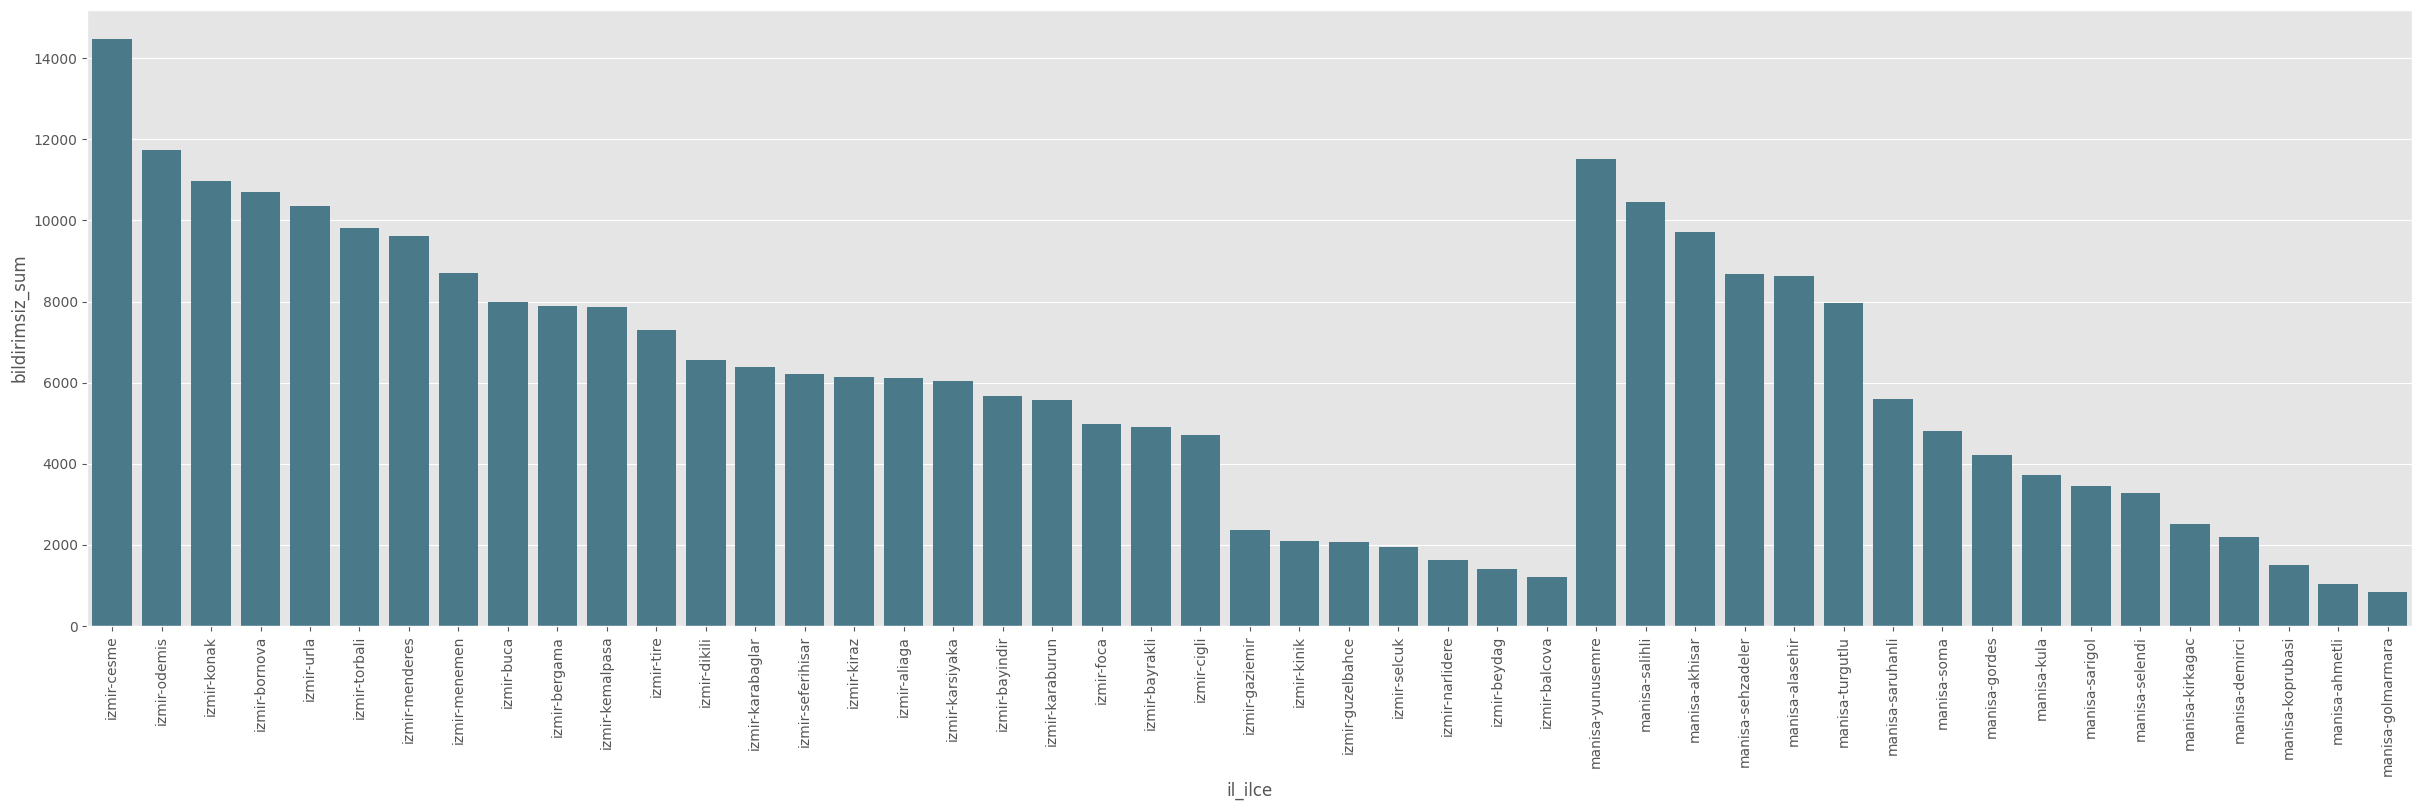

In [15]:
sorted_df = train_test_concat.groupby(["il", "ilce"])["bildirimsiz_sum"].sum().reset_index().sort_values(by=["il", "bildirimsiz_sum"], ascending=[True, False])
sorted_df["il_ilce"] = sorted_df["il"] + "-" + sorted_df["ilce"]
sorted_df = sorted_df.drop(columns=["il", "ilce"])
sorted_df = sorted_df[["il_ilce", "bildirimsiz_sum"]].reset_index(drop=True)
plt.figure(figsize=(30, 8))
sns.barplot(x="il_ilce", y="bildirimsiz_sum", data=sorted_df)
plt.xticks(rotation=90)
plt.show()

**Planlı kesintiye göre (bildirimli_sum) İl ve İlçe bazlı analiz**

**İl ve İlçe planlı kesinti toplam sayıları**
- İzmir ilinde toplam planlı kesinti sayısının en fazla olduğu ilk  3 ilçe bornova, ödemiş ve buca iken en az olan 3 ilçe güzelbahçe, balçova ve beydağ ilçeleridir. Planlı kesintide bornova ilk sıraya gelmiştir.
- Manisa ilinde toplam planlı kesinti sayısının en fazla olduğu ilk  3 ilçe akhisar, yunusemre, salihli iken en az olan 3 ilçe selendi, ahmetli ve gölmarmara ilçeleridir. Burdada ilk sıraya akhisar gelmiştir.
- Planlı kesintinin olduğu yerlerde altyapı çalışmaları olabilir.

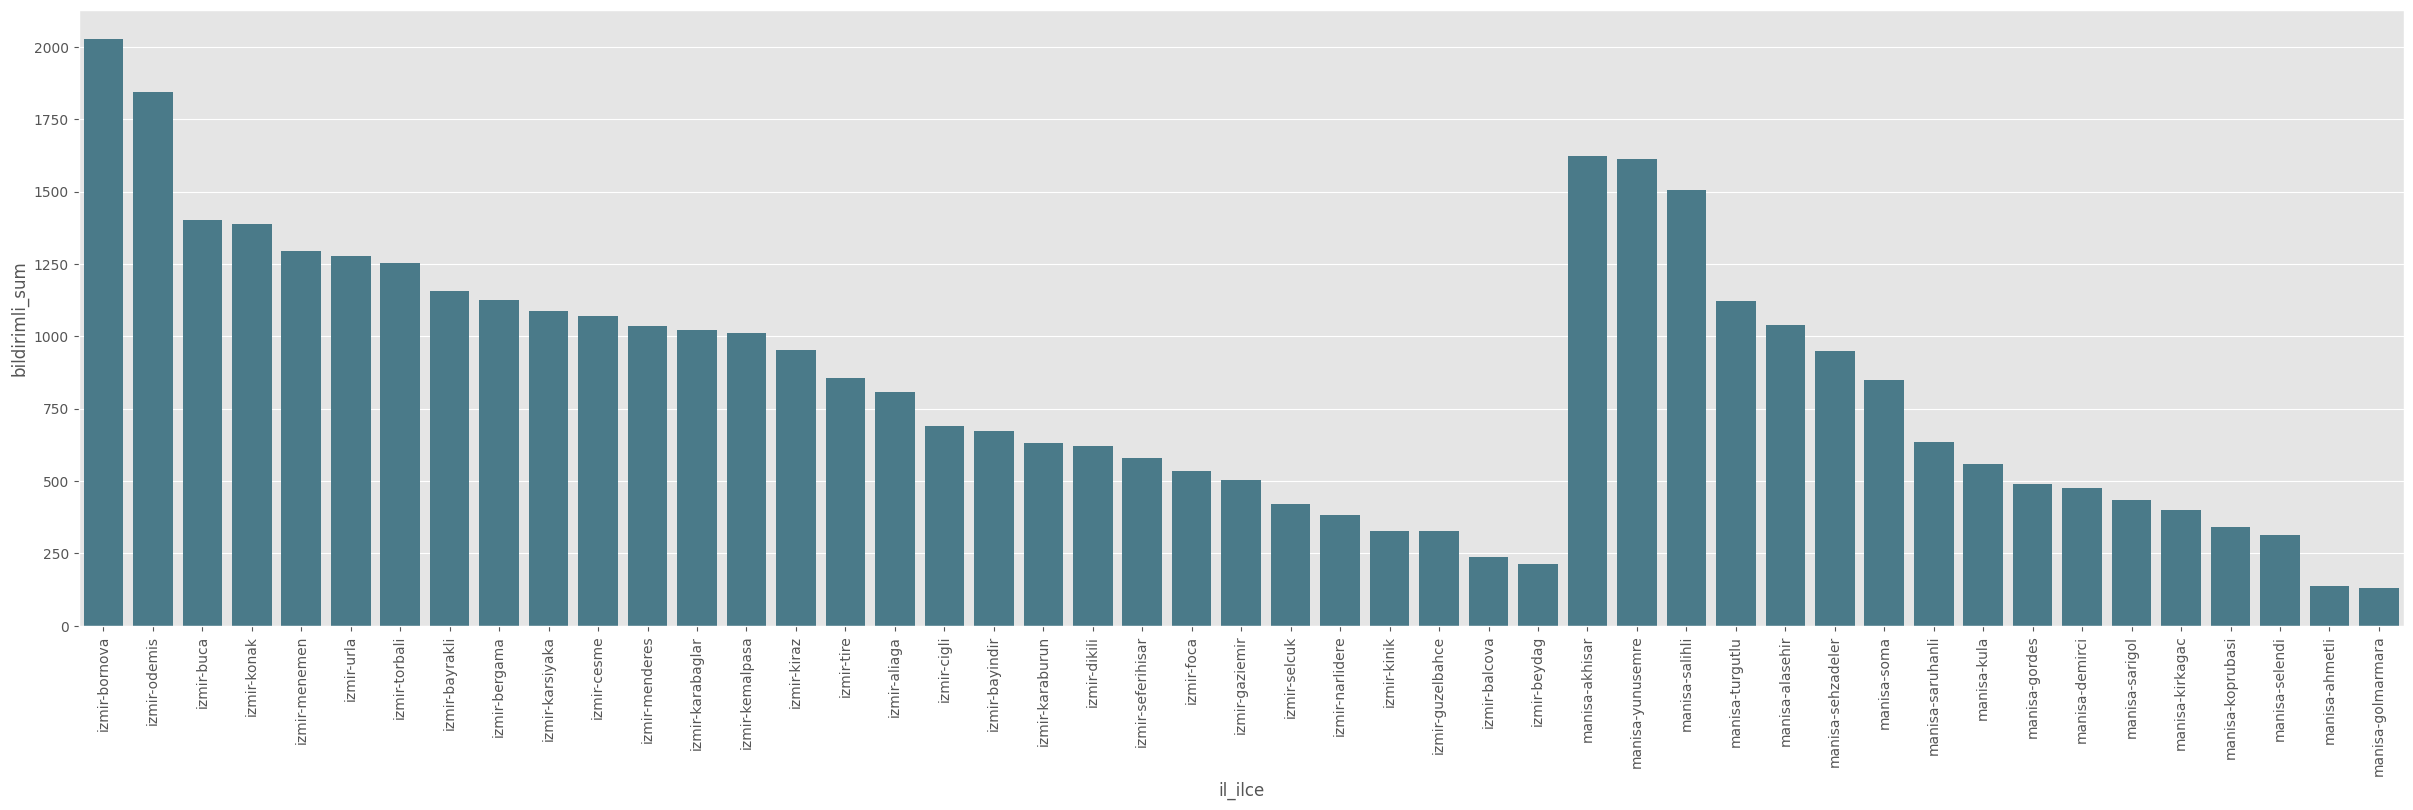

In [16]:
sorted_df_planli = train_test_concat.groupby(["il", "ilce"])["bildirimli_sum"].sum().reset_index().sort_values(by=["il", "bildirimli_sum"], ascending=[True, False])
sorted_df_planli["il_ilce"] = sorted_df_planli["il"] + "-" + sorted_df_planli["ilce"]
sorted_df_planli = sorted_df_planli.drop(columns=["il", "ilce"])
sorted_df_planli = sorted_df_planli[["il_ilce", "bildirimli_sum"]].reset_index(drop=True)

plt.figure(figsize=(30, 8))
sns.barplot(x="il_ilce", y="bildirimli_sum", data=sorted_df_planli)
plt.xticks(rotation=90)
plt.show()

**Tatil günleri bazlı analiz**
- Tatil günlerinden en fazla kesinti kurban bayramı ve demokrasi ve milli birlik gününde meydana gelmiş

Özel günlerin sayısı

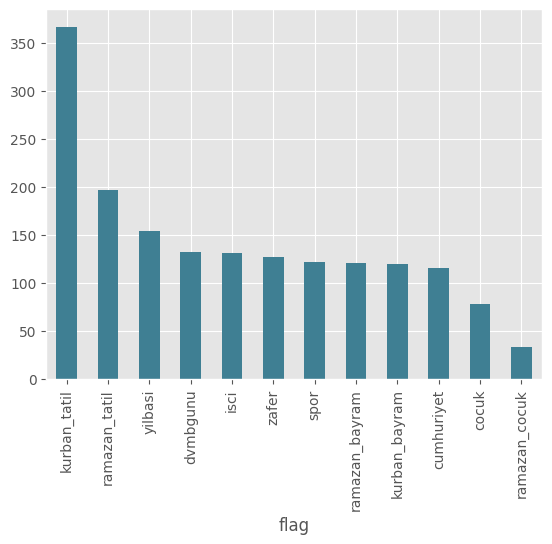

In [17]:
train_test_concat[train_test_concat["flag"]!="normal"]["flag"].value_counts().plot(kind="bar")
plt.show()

Özel günlere göre kesinti toplamları

In [18]:
holidays=train_test_concat.groupby("flag")["bildirimsiz_sum"].sum().reset_index().sort_values(by=["bildirimsiz_sum"], ascending=[False])
holidays_except_normal=holidays[holidays["flag"]!="normal"]

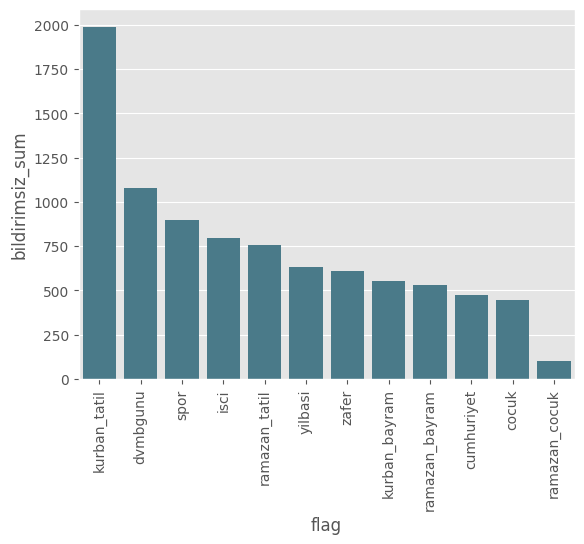

In [19]:
sns.barplot(x="flag",y="bildirimsiz_sum",data=holidays_except_normal)
plt.xticks(rotation=90)
plt.show()

**Sayısal Değişkenlerin Analizi**

In [20]:
def single_variable_multiple_plot(data:pd.DataFrame,numeric=True):
    """
    Veri setindeki tek bir sayısal değişken için histogram, boxplot grafiği ve çekirdek yoğunluk grafiği.
    Kategorik değişken için countplot grafiği ve pasta grafiği kullanarak görselleştirir.

    Parametreler:
    data : DataFrame Veri kümesi.
    type : str, opsiyonel, Sayısal değişkenlerin veri tipi. Varsayılan 'float64'tür.
    numeric : bool, opsiyonel, True ise, grafikler sayısal değişkenler için oluşturulur; False ise, grafikler kategorik değişkenler için oluşturulur. Varsayılan True'dur.

    Returns:
    None
    """
 
    if numeric: 
         numeric_columns= [col for col in data.columns if data[col].dtype in ["float64","int64","float32","int32"]]
         for i in numeric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
            sns.histplot(x=data[i],bins=10,ax=axes[0])
            axes[0].set_title(i)
            sns.boxplot(x=data[i],ax=axes[1])
            axes[1].set_title(i)
            sns.kdeplot(x=data[i],ax=axes[2])
            axes[2].set_title(i)
            plt.show()
    
    else:
         categoric_columns= [col for col in data.columns if data[col].dtype in ["object","category"]]
         for i in categoric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
            sns.countplot(data=data, x=i,order=data[i].value_counts().index, ax=axes[0])
            axes[0].set_title(i)
            axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
            plt.pie(data[i].value_counts(), autopct='%1.1f%%',labels=data[i].value_counts().index)
            axes[1].set_title(i)
            axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
            plt.tight_layout()
            plt.show()

In [21]:
train_test_concat.describe().T

,count,mean,std,min,25%,50%,75%,max
bildirimsiz_sum,48148.0,5.886911,5.425645,0.0000,2.0000,4.0000,8.0000,93.0000
bildirimli_sum,49511.0,0.795056,1.309763,0.0000,0.0000,0.0000,1.0000,19.0000
lat,49511.0,38.535126,0.301920,37.9508,38.3250,38.4710,38.7375,39.1881
long,49511.0,27.502125,0.625106,26.3032,27.0697,27.3818,27.9170,28.8693
temp,49511.0,22.656125,8.893033,-2.7000,15.8000,21.9000,30.0000,44.8000
cloud_cover,49511.0,59.598253,37.431510,0.0000,24.9000,64.8000,98.8000,100.0000
global_rad,49511.0,669.067932,223.410178,27.6000,491.5000,691.1000,870.5500,1026.3000
relative_humidity,49511.0,83.483355,12.293861,30.3000,75.5000,85.7000,93.3000,100.0000
wind_dir,49511.0,156.199457,75.806460,5.0000,106.5000,155.8000,203.4000,352.3000
wind_speed,49511.0,4.496383,2.006146,0.7000,3.0000,4.2000,5.6000,18.4000


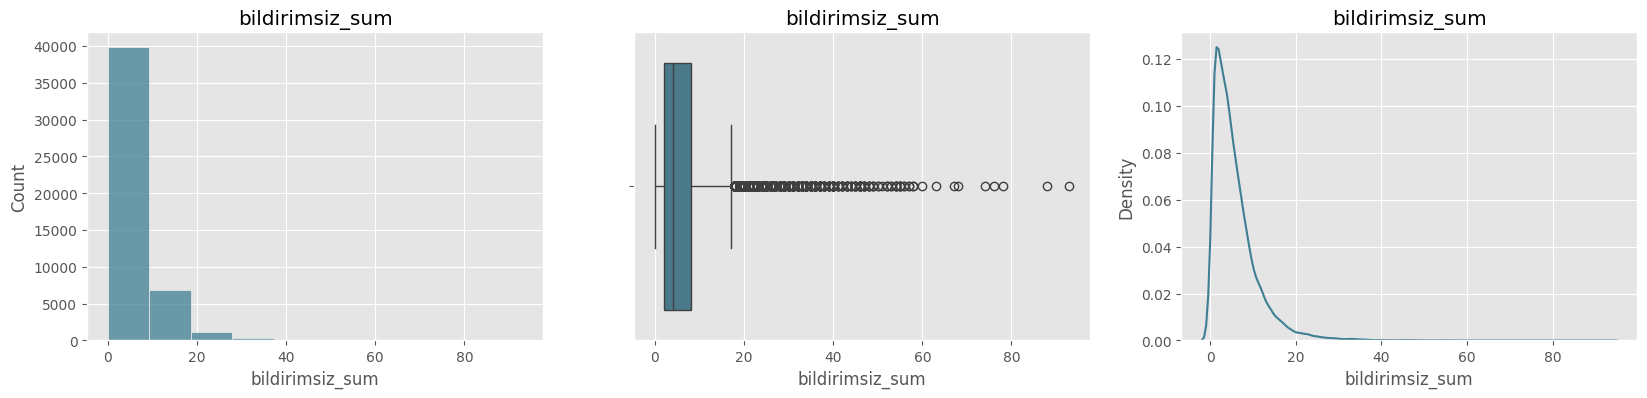

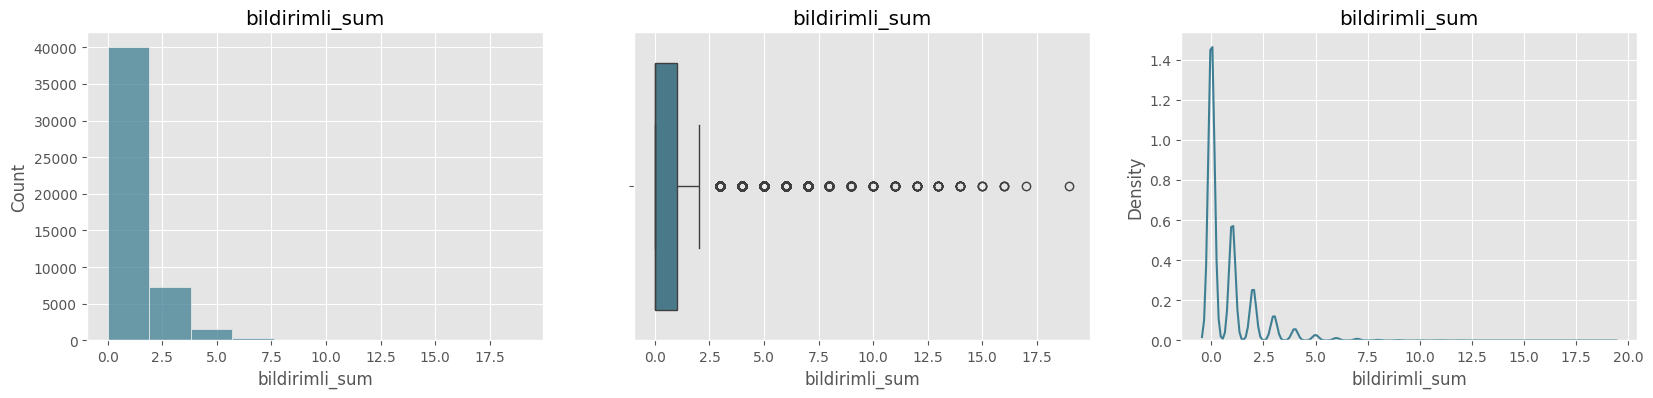

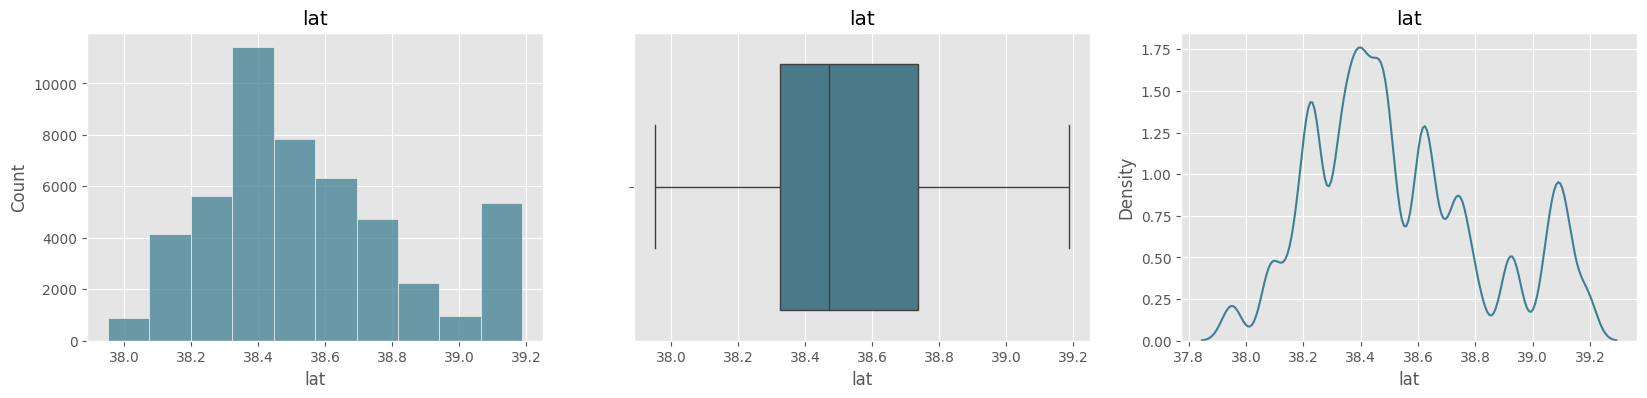

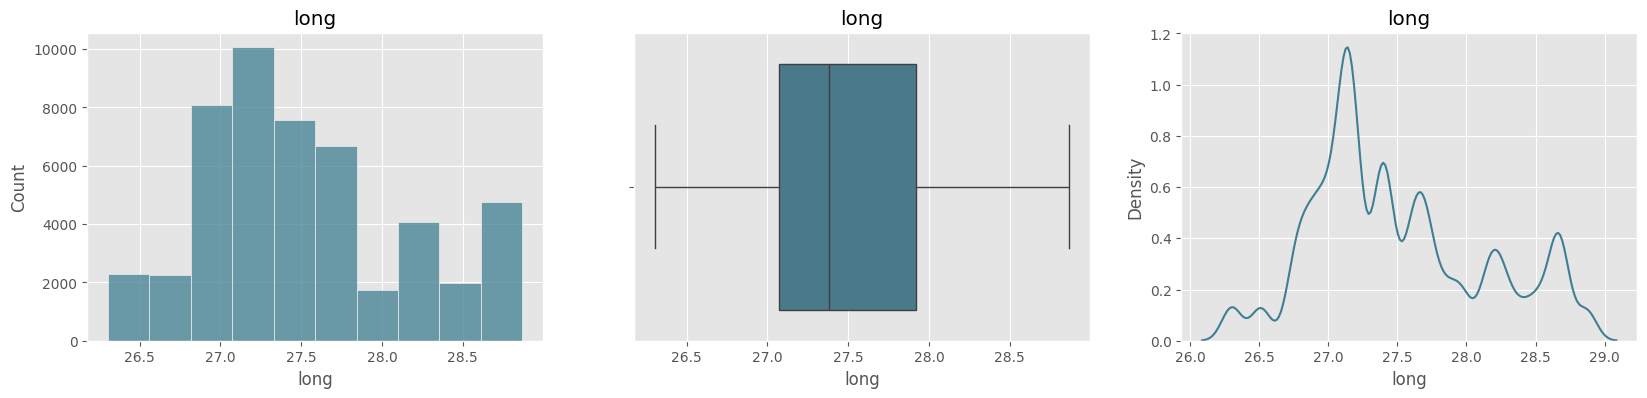

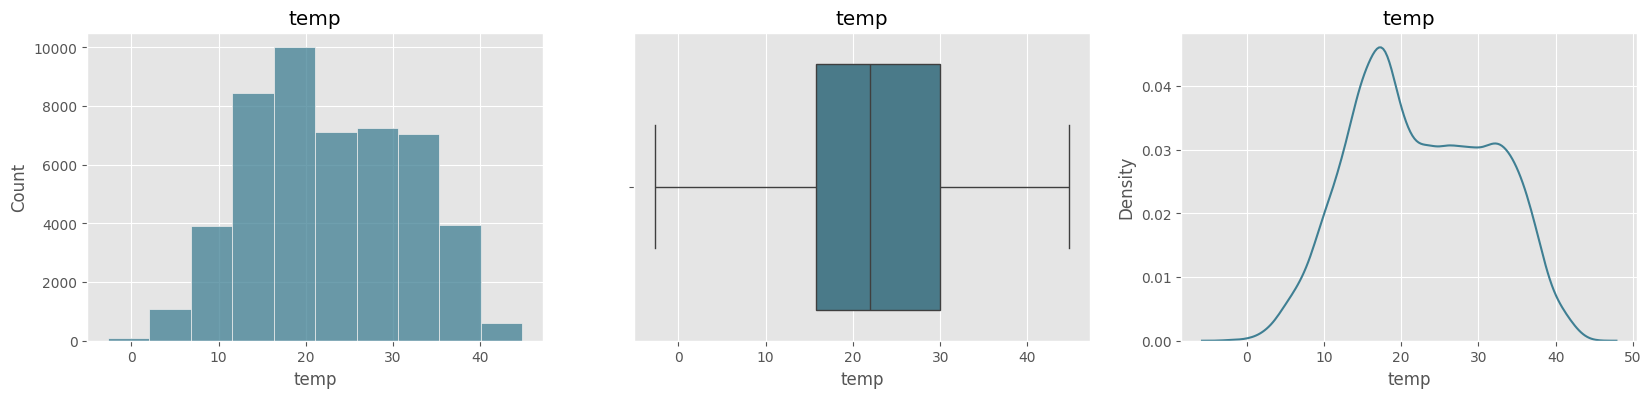

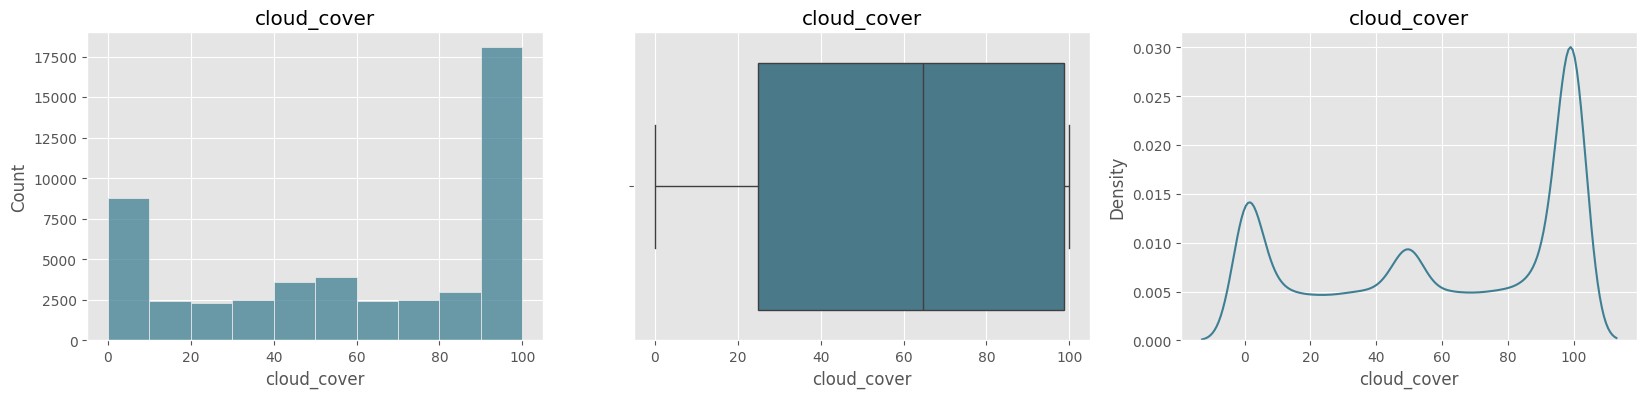

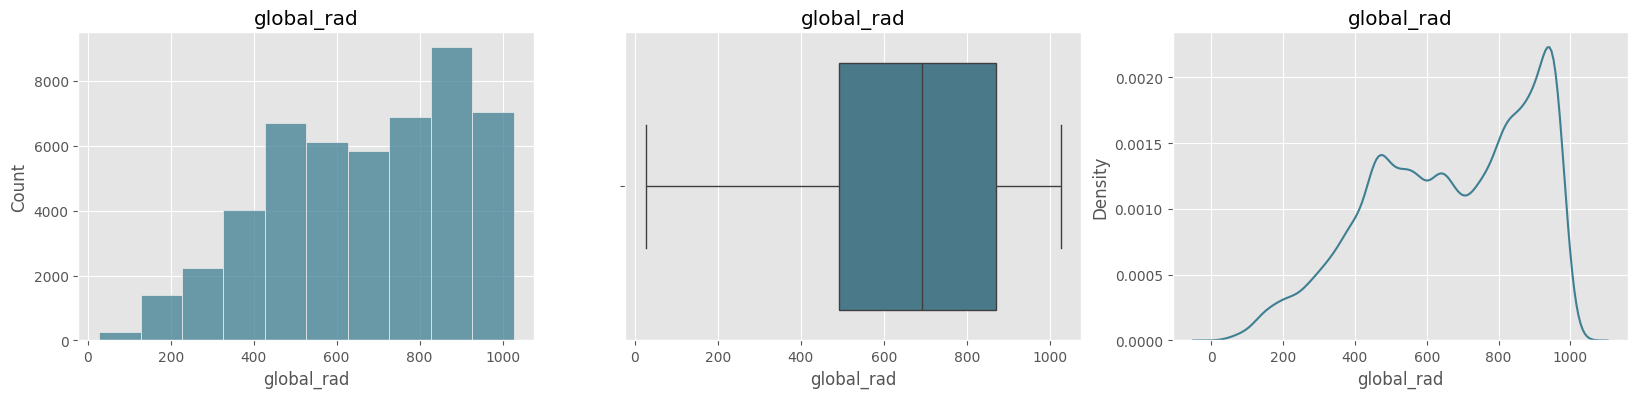

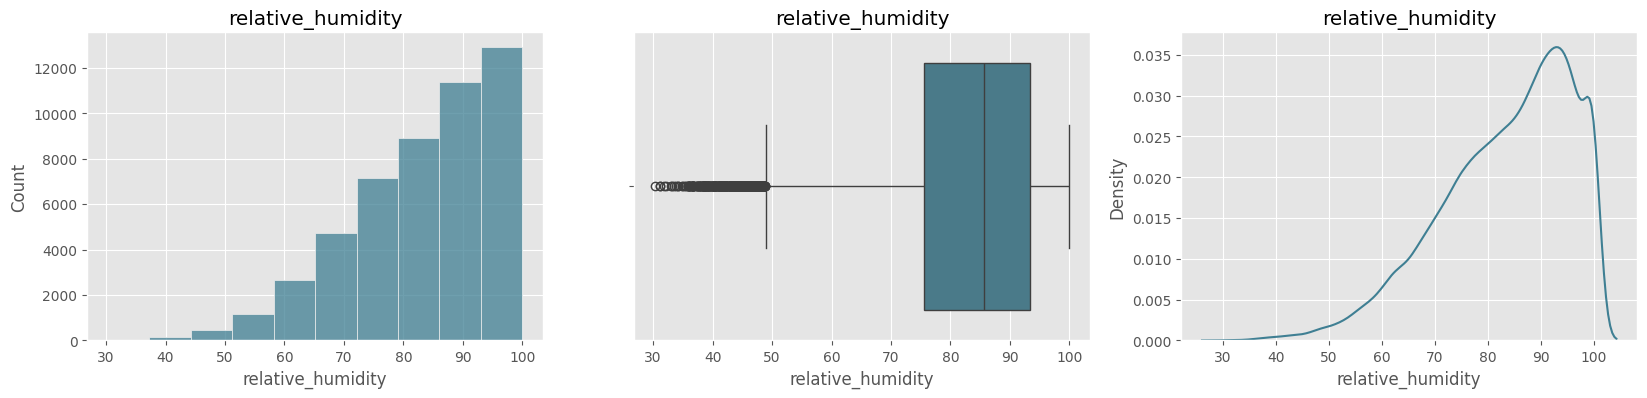

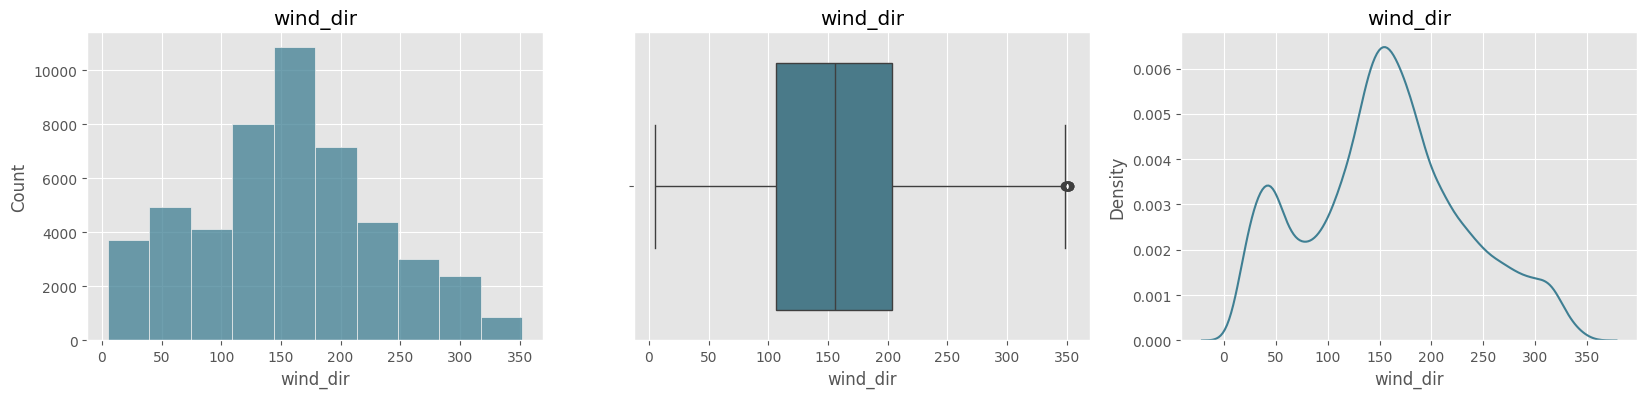

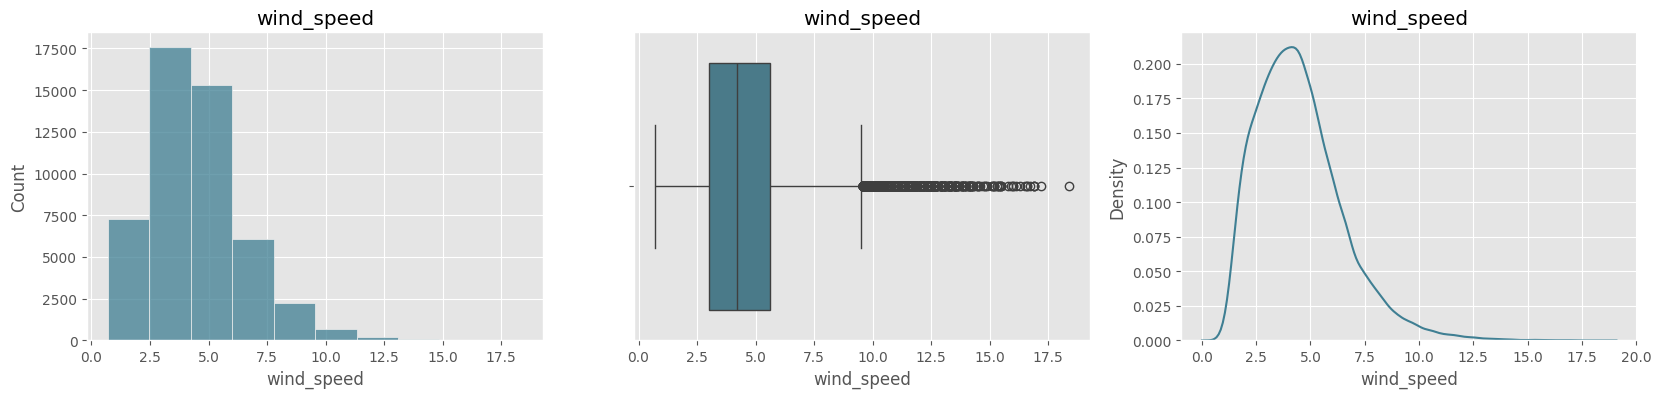

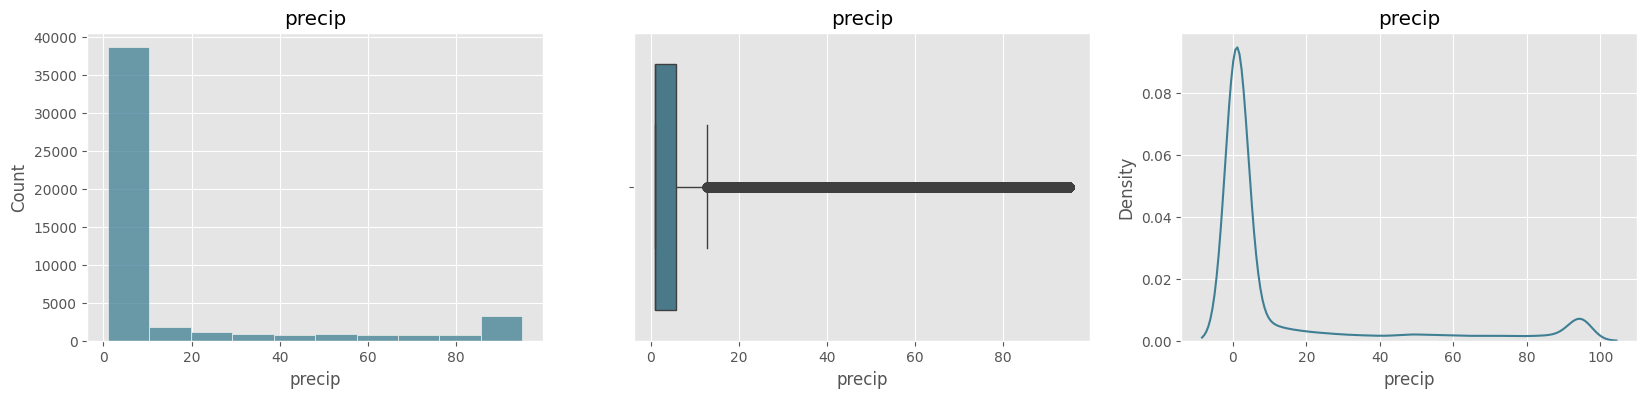

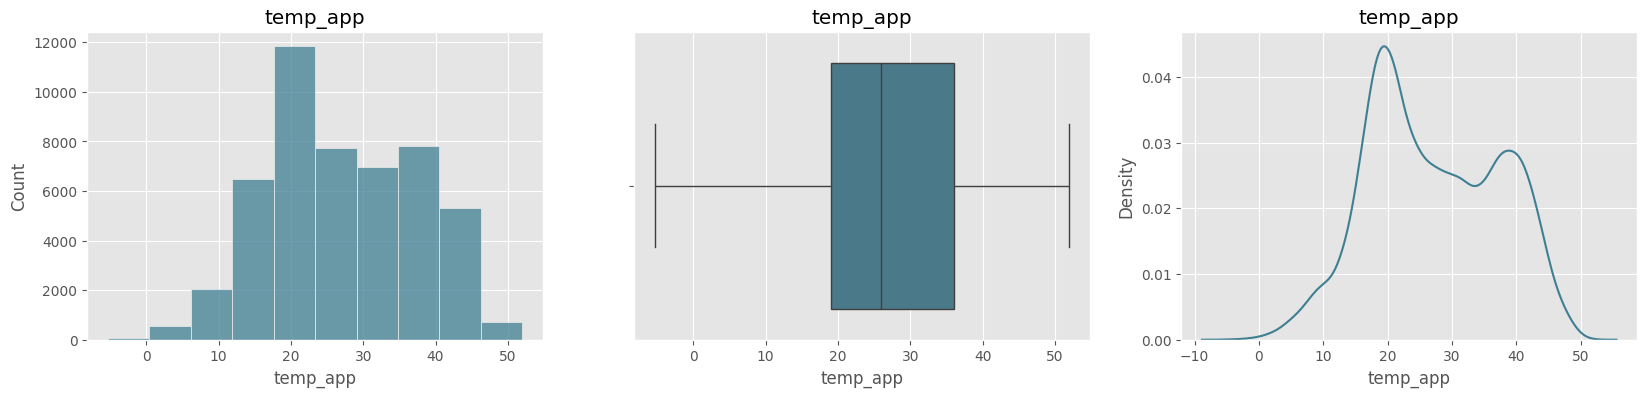

In [22]:
single_variable_multiple_plot(train_test_concat,numeric=True)

**Bildirmli - Bildirimsiz sum aykırı değerler**

**Bildirimsiz**

In [23]:
def outlier_thresholds(dataframe:pd.DataFrame, variable:str, q1_thr=0.25, q3_thr=0.75):
    """
    Calculate the lower and upper bounds to cap outliers in a variable.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The DataFrame containing the variable.
    variable : str
        The name of the variable for which to calculate the outlier thresholds.
    q1_thr : float, optional
        The quantile value for the lower quartile. Default is 0.25.
    q3_thr : float, optional
        The quantile value for the upper quartile. Default is 0.75.

    Returns
    -------
    low_limit : float
        The lower bound threshold for capping outliers.
    up_limit : float
        The upper bound threshold for capping outliers.
    """
    quartile1 = dataframe[variable].quantile(q1_thr)
    quartile3 = dataframe[variable].quantile(q3_thr)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [24]:
train_test_concat[["bildirimsiz_sum"]].describe([0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98]).T

,count,mean,std,min,2%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,98%,max
bildirimsiz_sum,48148.0,5.886911,5.425645,0.0,0.0,1.0,1.0,2.0,3.0,4.0,4.0,6.0,7.0,9.0,12.0,16.0,21.0,93.0


In [25]:
train_test_concat.loc[train_test_concat["bildirimsiz_sum"]> 21, ["il_ilce","bildirimli_sum","bildirimsiz_sum"]].shape

(954, 3)

In [26]:
low_limit, up_limit = outlier_thresholds(train_test_concat,"bildirimsiz_sum",q1_thr=0.10, q3_thr=0.90)
train_test_concat[(train_test_concat["bildirimsiz_sum"] < low_limit) | (train_test_concat["bildirimsiz_sum"] > up_limit)].shape

(349, 18)

In [27]:
train_test_concat.loc[(train_test_concat["bildirimsiz_sum"] > up_limit), "bildirimsiz_sum"] = up_limit

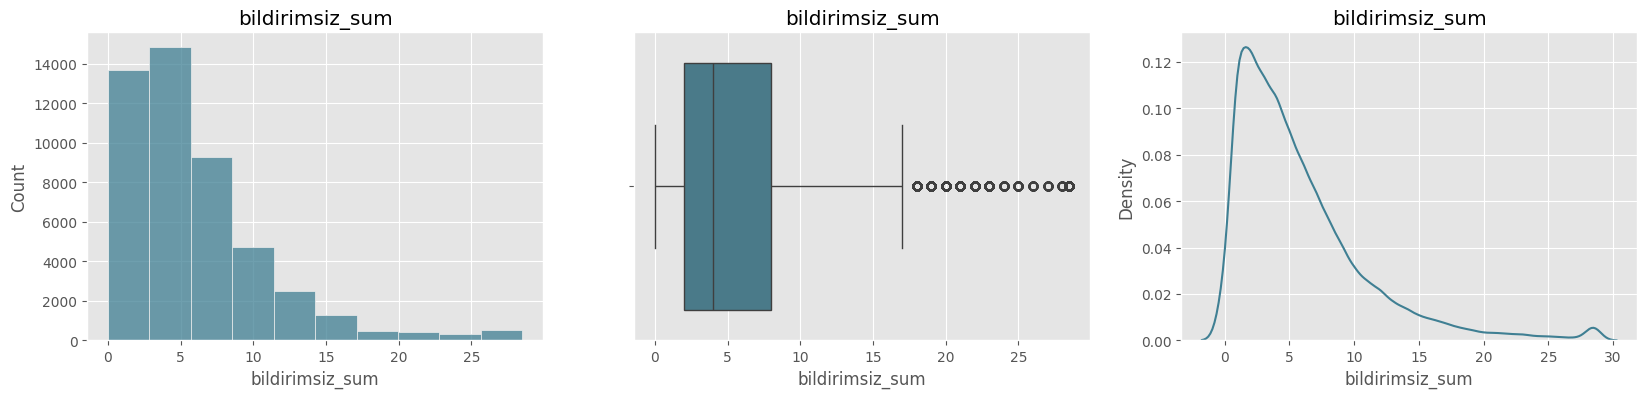

In [28]:
single_variable_multiple_plot(train_test_concat[["bildirimsiz_sum"]],numeric=True)

**Bildirimli**

In [29]:
train_test_concat[["bildirimli_sum"]].describe([0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98]).T

,count,mean,std,min,2%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,98%,max
bildirimli_sum,49511.0,0.795056,1.309763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0,5.0,19.0


In [30]:
train_test_concat.loc[train_test_concat["bildirimli_sum"]> 5, ["il_ilce","bildirimli_sum","bildirimli_sum"]].shape

(550, 3)

In [31]:
low_limit, up_limit = outlier_thresholds(train_test_concat,"bildirimli_sum",q1_thr=0.10, q3_thr=0.90)
train_test_concat[(train_test_concat["bildirimli_sum"] < low_limit) | (train_test_concat["bildirimli_sum"] > up_limit)].shape

(550, 18)

In [32]:
train_test_concat.loc[(train_test_concat["bildirimli_sum"] > up_limit), "bildirimli_sum"] = up_limit

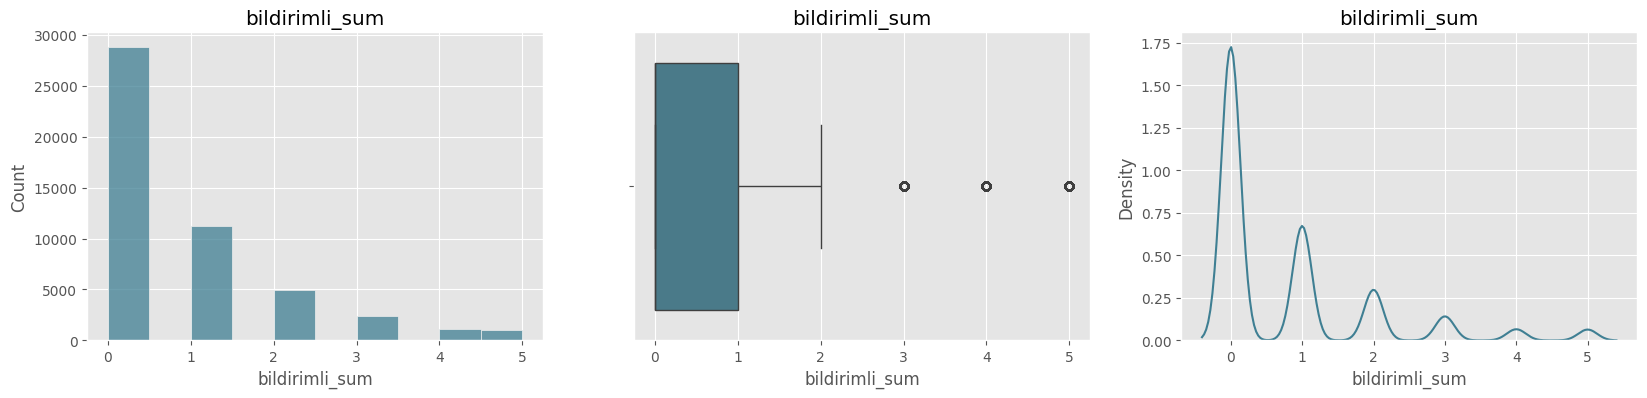

In [33]:
single_variable_multiple_plot(train_test_concat[["bildirimli_sum"]],numeric=True)

**Tarih Değişkenlerinin Eklenmesi**
- Yıl ve ay etkili olabileceği için oranlar yıl ve aya göre oluşturuldu.

In [34]:
train_test_concat[["year","month","day"]] = train_test_concat["tarih"].str.split("-",expand=True).astype(int)

**Yıl değişkeni**

**Bildirimsiz**

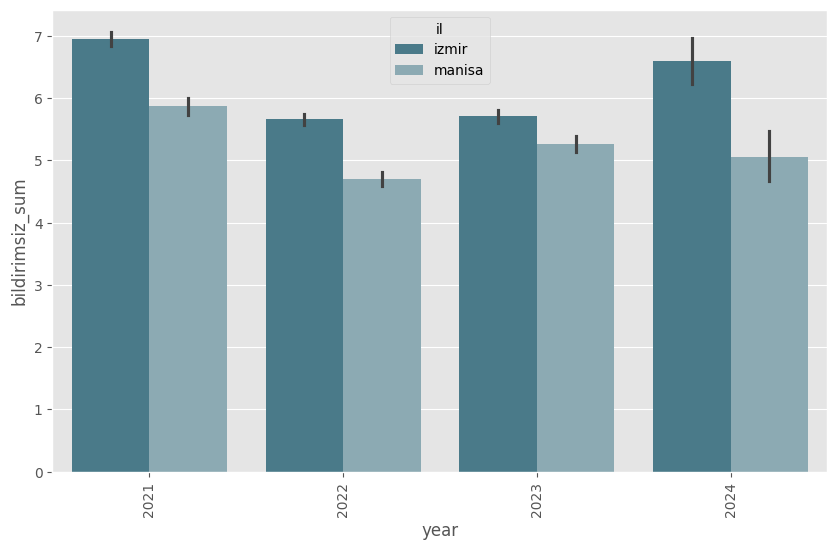

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(x="year", y="bildirimsiz_sum",hue="il",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [36]:
def add_ratio_by_category(df:pd.DataFrame, category:str, target:str):
    new_ratio_feature_name = f"{category}_{target}_ratio"
    temp_df = df.groupby(category)[target].sum().reset_index()
    temp_df[new_ratio_feature_name] = temp_df[target] / temp_df[target].sum()
    temp_df.drop(target, axis=1, inplace=True)
    temp_series=temp_df.set_index(category)[new_ratio_feature_name]
    df[new_ratio_feature_name] = df[category].map(temp_series)
    print(f"New {new_ratio_feature_name} has been added to dataframe.")
    print("-------------------------------------------------")
    print(df.groupby(category)[new_ratio_feature_name].mean().reset_index().head())

**Bildirimsiz_sum değişkeninin yıllık bazda oranı veri setine özellik olarak eklenmiştir.**

In [37]:
add_ratio_by_category(train_test_concat, "year", "bildirimsiz_sum")

New year_bildirimsiz_sum_ratio has been added to dataframe.
-------------------------------------------------
   year  year_bildirimsiz_sum_ratio
0  2021                    0.369362
1  2022                    0.292872
2  2023                    0.309214
3  2024                    0.028551


**Bildirimli**

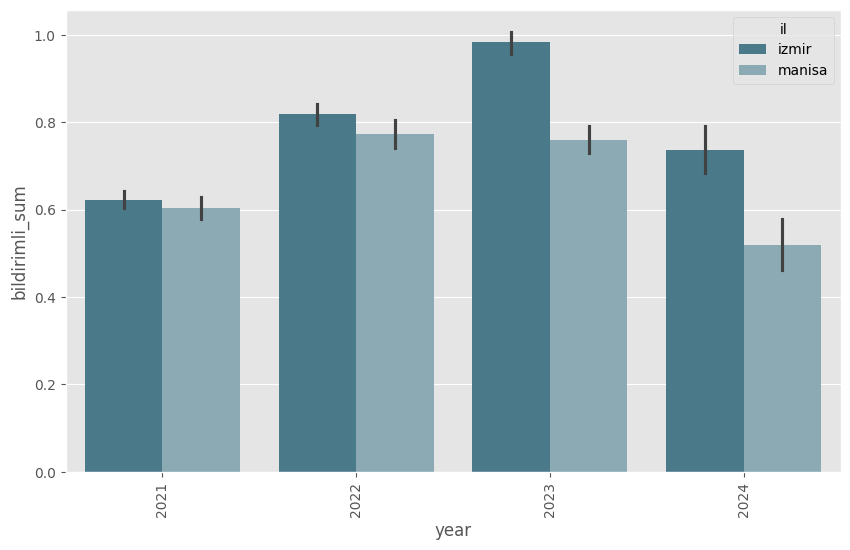

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x="year", y="bildirimli_sum",hue="il",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

**Ay Değişkeni**

**Bildirimsiz**

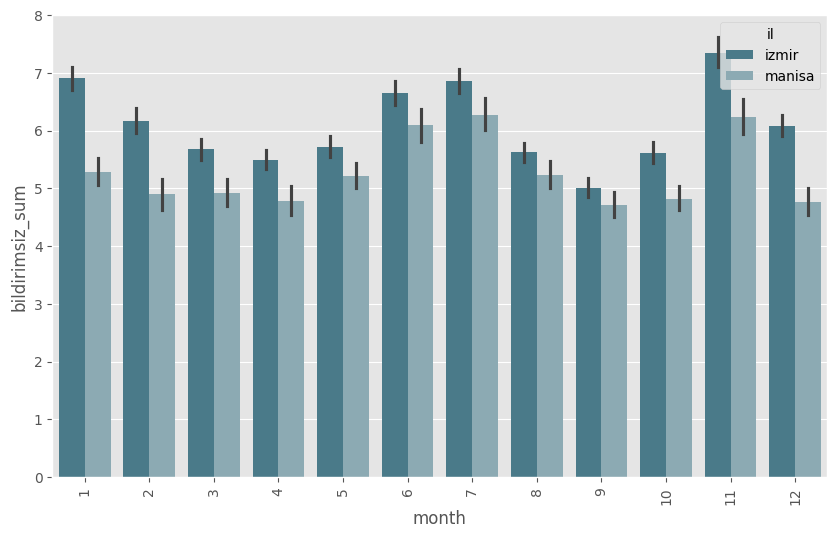

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(x="month", y="bildirimsiz_sum",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

**Bildirimli**

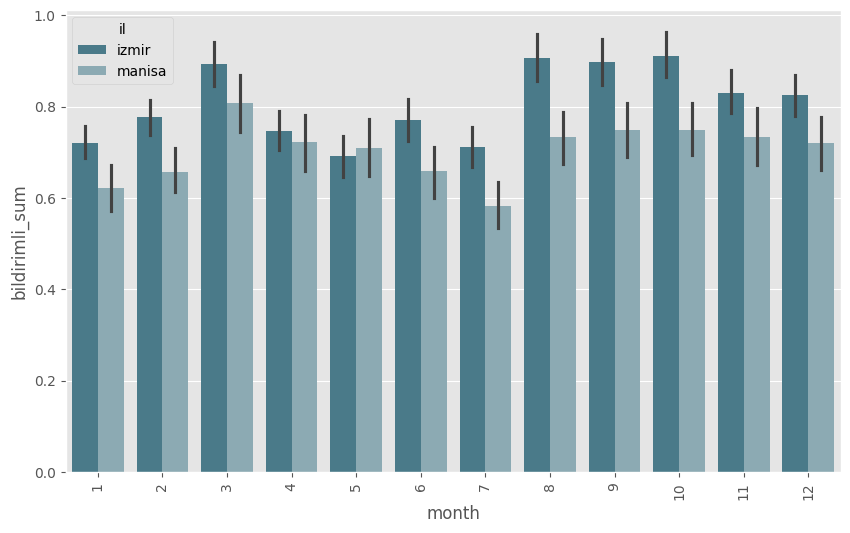

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x="month", y="bildirimli_sum",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

**Gün Değişkeni**

**Bildirimsiz**

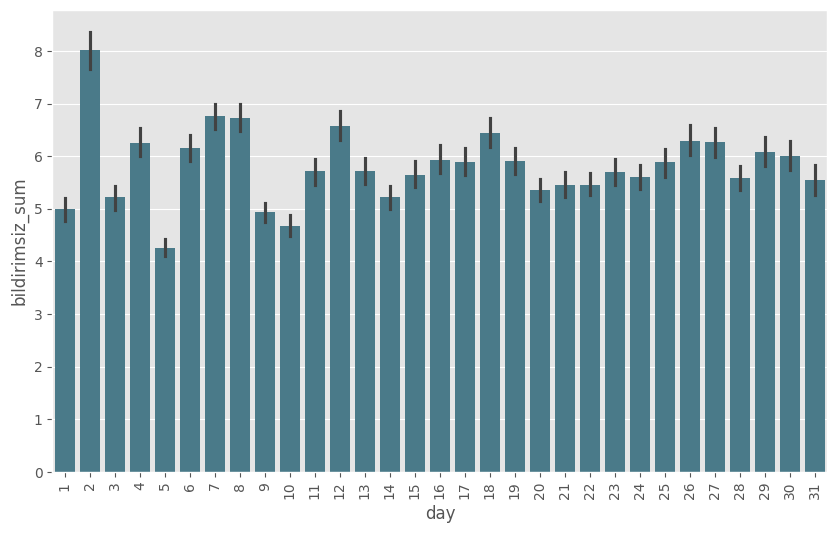

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(x="day", y="bildirimsiz_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

**Bildirimli**

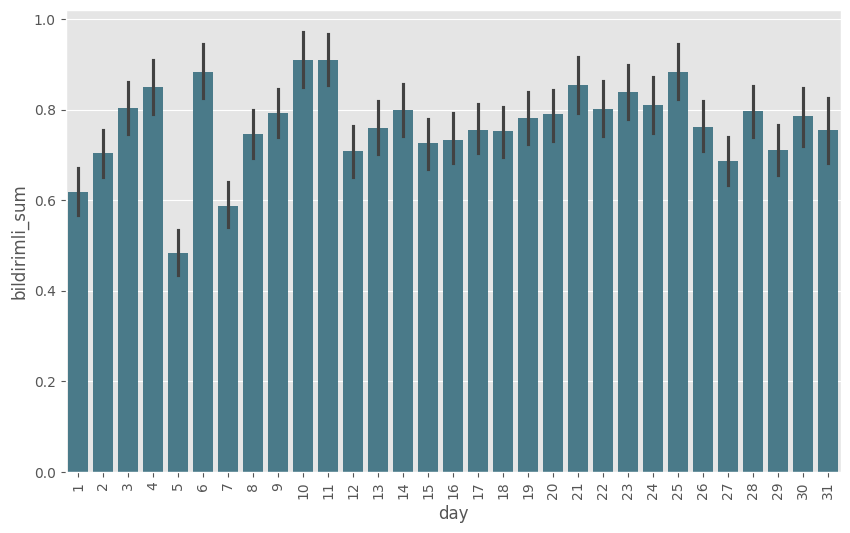

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(x="day", y="bildirimli_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

**Weekday(haftanın hangi günü)  değişkeni eklenmesi**

In [43]:
train_test_concat["tarih"] = pd.to_datetime(train_test_concat["tarih"])
train_test_concat["weekday"] = train_test_concat["tarih"].dt.weekday
train_test_concat["tarih"] = train_test_concat["tarih"].dt.strftime("%Y-%m-%d") 

**Weekday bildirimsiz**

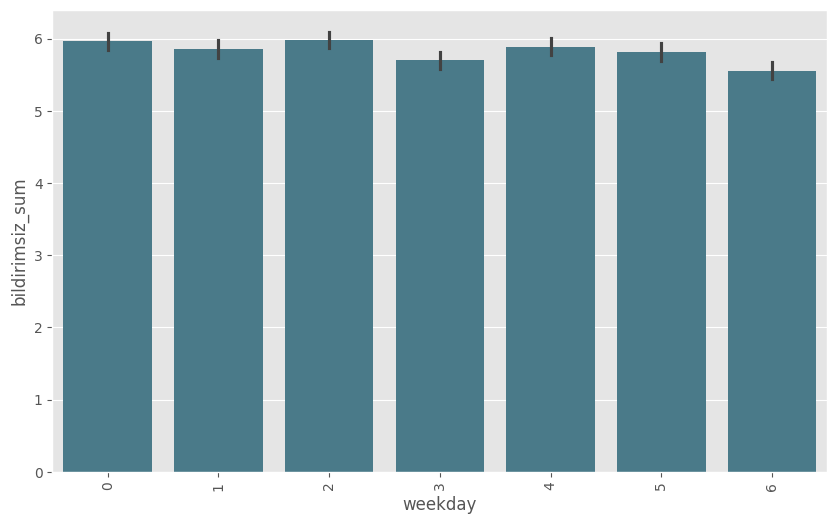

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(x="weekday", y="bildirimsiz_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

**Weekday bildirimli**

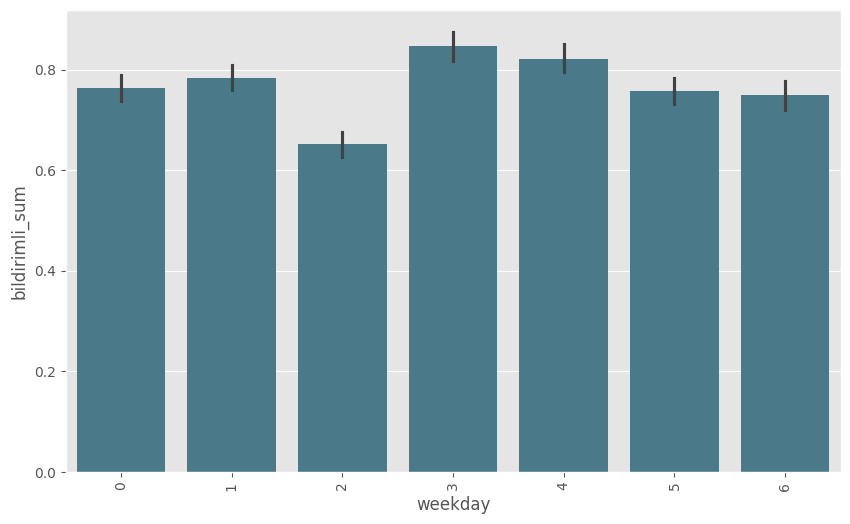

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(x="weekday", y="bildirimli_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

**Kategorik Değişken Oluşturulması**

**Yıllık bildirimsiz sum değerindeki değişimlere göre il ilçe bazlı bildirimsiz_sum KPI oluşturulması**
- 2021 - 2022 yılları arasındaki değişime %60, 2022 - 2023 yılları arasındaki değişime %40 ağırlık verilmiştir. 2024 de yeterli bilgi olmadığından kullanılmamıştır.
- Bu nedenle, %60-%40 ağırlıklandırma stratejisi, geçmiş verilerin gelecekteki performansı daha iyi tahmin edebileceğine dair bir inancı yansıtır.

In [46]:
temp_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
temp_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]

In [47]:
pivot_table = temp_train.pivot_table(index="il_ilce",columns="year",values="bildirimsiz_sum",aggfunc="sum")
pivot_table.sort_values(2021,ascending=False,inplace=True)
pivot_table.head()

year,2021,2022,2023,2024
il_ilce,,,,
izmir-cesme,5338.0,4777.0,3826.0,301.0
izmir-odemis,4460.0,3609.5,3202.0,193.5
manisa-yunusemre,4328.0,3402.0,3269.5,296.5
izmir-urla,4238.5,2929.5,2745.5,248.5
izmir-menderes,3827.0,2849.5,2719.5,169.5


In [48]:
pivot_table["dusus_orani_2021_2022"] = ((pivot_table[2021] - pivot_table[2022]) / pivot_table[2021]) * 100
pivot_table["dusus_orani_2023_2023"] = ((pivot_table[2022] - pivot_table[2023]) / pivot_table[2021]) * 100
pivot_table["il_ilce_bildirimsiz_sum_KPI"] = (pivot_table["dusus_orani_2021_2022"] * 0.6) + (pivot_table["dusus_orani_2023_2023"] * 0.4)

In [49]:
pivot_table.drop(["dusus_orani_2021_2022","dusus_orani_2023_2023",2021,2022,2023,2024],inplace=True,axis=1)

In [50]:
pivot_table.sort_values(by="il_ilce_bildirimsiz_sum_KPI", ascending=False, inplace=True)
pivot_series = pivot_table["il_ilce_bildirimsiz_sum_KPI"]
train_test_concat["il_ilce_bildirimsiz_sum_KPI"] = train_test_concat["il_ilce"].map(pivot_series)
train_test_concat.groupby("il_ilce")["il_ilce_bildirimsiz_sum_KPI"].mean().reset_index().sort_values("il_ilce_bildirimsiz_sum_KPI", ascending=False).head()

,il_ilce,il_ilce_bildirimsiz_sum_KPI
5,izmir-beydag,31.814224
15,izmir-karaburun,22.216393
29,izmir-urla,20.266604
2,izmir-bayindir,17.011646
14,izmir-karabaglar,16.934046


**Bildirimli**

In [51]:
pivot_table = temp_train.pivot_table(index="il_ilce",columns="year",values="bildirimli_sum",aggfunc="sum")
pivot_table.sort_values(2021,ascending=False,inplace=True)
pivot_table.head()

year,2021,2022,2023,2024
il_ilce,,,,
manisa-salihli,479,431,496,20
izmir-odemis,457,578,668,63
izmir-bornova,427,455,818,56
izmir-urla,420,327,441,29
manisa-akhisar,398,525,553,29


In [52]:
pivot_table["dusus_orani_2021_2022"] = ((pivot_table[2021] - pivot_table[2022]) / pivot_table[2021]) * 100
pivot_table["dusus_orani_2023_2023"] = ((pivot_table[2022] - pivot_table[2023]) / pivot_table[2021]) * 100
pivot_table["il_ilce_bildirimli_sum_KPI"] = (pivot_table["dusus_orani_2021_2022"] * 0.6) + (pivot_table["dusus_orani_2023_2023"] * 0.4)

In [53]:
pivot_table.drop(["dusus_orani_2021_2022","dusus_orani_2023_2023",2021,2022,2023,2024],inplace=True,axis=1)

In [54]:
pivot_table.sort_values(by="il_ilce_bildirimli_sum_KPI", ascending=False, inplace=True)
pivot_series = pivot_table["il_ilce_bildirimli_sum_KPI"]
train_test_concat["il_ilce_bildirimli_sum_KPI"] = train_test_concat["il_ilce"].map(pivot_series)
train_test_concat.groupby("il_ilce")["il_ilce_bildirimli_sum_KPI"].mean().reset_index().sort_values("il_ilce_bildirimli_sum_KPI", ascending=False).head()

,il_ilce,il_ilce_bildirimli_sum_KPI
33,manisa-demirci,13.173653
2,izmir-bayindir,12.750000
43,manisa-selendi,10.204082
41,manisa-saruhanli,8.225108
17,izmir-kemalpasa,7.384615


**KMeans ile ilçelerin segmentlerinin çıkarılması**

In [55]:
temp_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
temp_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]

In [56]:
segment_features_df = temp_train.groupby("il_ilce")[["bildirimsiz_sum","bildirimli_sum","lat","long","temp","cloud_cover","global_rad","wind_dir","wind_speed","precip"]].mean().reset_index()
segment_features_df.head()

,il_ilce,bildirimsiz_sum,bildirimli_sum,lat,long,temp,cloud_cover,global_rad,wind_dir,wind_speed,precip
0,izmir-aliaga,5.522152,0.716094,38.7996,26.9707,22.200090,57.369078,672.771067,121.555515,6.225588,13.535714
1,izmir-balcova,1.733524,0.338109,38.3891,27.0500,21.688825,58.494556,661.738252,202.944269,5.074928,14.715330
2,izmir-bayindir,5.125339,0.592760,38.2178,27.6478,24.329050,58.990860,677.091403,110.109412,4.358009,13.459548
3,izmir-bayrakli,4.447514,0.970534,38.4612,27.1881,23.963168,57.425046,671.323481,129.462615,4.504236,13.323481
4,izmir-bergama,6.987946,0.967857,39.1214,27.1799,22.755179,63.777232,655.931161,107.660893,4.788393,13.354286


**Elbow**

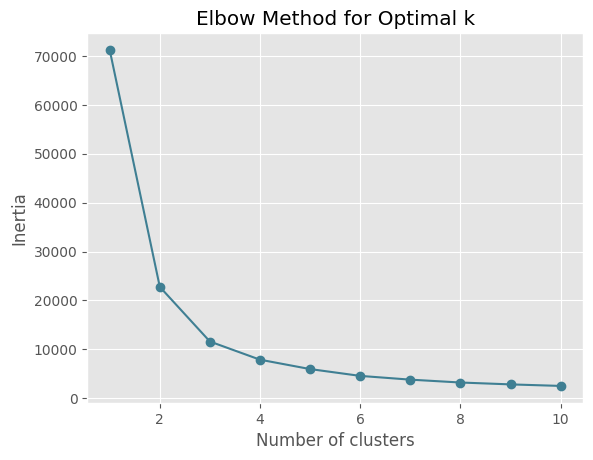

In [57]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=100)
    kmeans.fit(segment_features_df.select_dtypes(exclude="object"))
    inertia.append(kmeans.inertia_)

# Elbow yöntemi ile belirlenen küme sayısını görselleştirin
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [58]:
pipeline = Pipeline([("scaler",StandardScaler()),
                    ("kmeans",KMeans(n_clusters=3,random_state=42,n_init=100))])
pipeline.fit(segment_features_df.select_dtypes(exclude="object"))
segment_features_df["kmeans_segments_of_county"] = pipeline.predict(segment_features_df.select_dtypes(exclude="object"))
segment_features_df.head()

,il_ilce,bildirimsiz_sum,bildirimli_sum,lat,long,temp,cloud_cover,global_rad,wind_dir,wind_speed,precip,kmeans_segments_of_county
0,izmir-aliaga,5.522152,0.716094,38.7996,26.9707,22.200090,57.369078,672.771067,121.555515,6.225588,13.535714,1
1,izmir-balcova,1.733524,0.338109,38.3891,27.0500,21.688825,58.494556,661.738252,202.944269,5.074928,14.715330,2
2,izmir-bayindir,5.125339,0.592760,38.2178,27.6478,24.329050,58.990860,677.091403,110.109412,4.358009,13.459548,0
3,izmir-bayrakli,4.447514,0.970534,38.4612,27.1881,23.963168,57.425046,671.323481,129.462615,4.504236,13.323481,0
4,izmir-bergama,6.987946,0.967857,39.1214,27.1799,22.755179,63.777232,655.931161,107.660893,4.788393,13.354286,2


In [59]:
segment_series = segment_features_df[["il_ilce","kmeans_segments_of_county"]].set_index("il_ilce")["kmeans_segments_of_county"]
train_test_concat["kmeans_segments_of_county"] = train_test_concat["il_ilce"].map(segment_series)
train_test_concat.groupby(["il_ilce","kmeans_segments_of_county"])[["bildirimli_sum","bildirimsiz_sum"]].sum().reset_index().head()

,il_ilce,kmeans_segments_of_county,bildirimli_sum,bildirimsiz_sum
0,izmir-aliaga,1,798,6107.5
1,izmir-balcova,2,236,1210.0
2,izmir-bayindir,0,670,5663.5
3,izmir-bayrakli,0,1079,4830.0
4,izmir-bergama,2,1114,7826.5


In [60]:
segment_kmeans_df = train_test_concat.groupby(["il", "ilce","kmeans_segments_of_county"])["bildirimsiz_sum"].sum().reset_index().sort_values(by=["il", "bildirimsiz_sum"], ascending=[True, False])
segment_kmeans_df["il_ilce"] = segment_kmeans_df["il"] + "-" + segment_kmeans_df["ilce"]
segment_kmeans_df = segment_kmeans_df.drop(columns=["il", "ilce"])
segment_kmeans_df = segment_kmeans_df[["il_ilce", "bildirimsiz_sum","kmeans_segments_of_county"]].reset_index(drop=True)

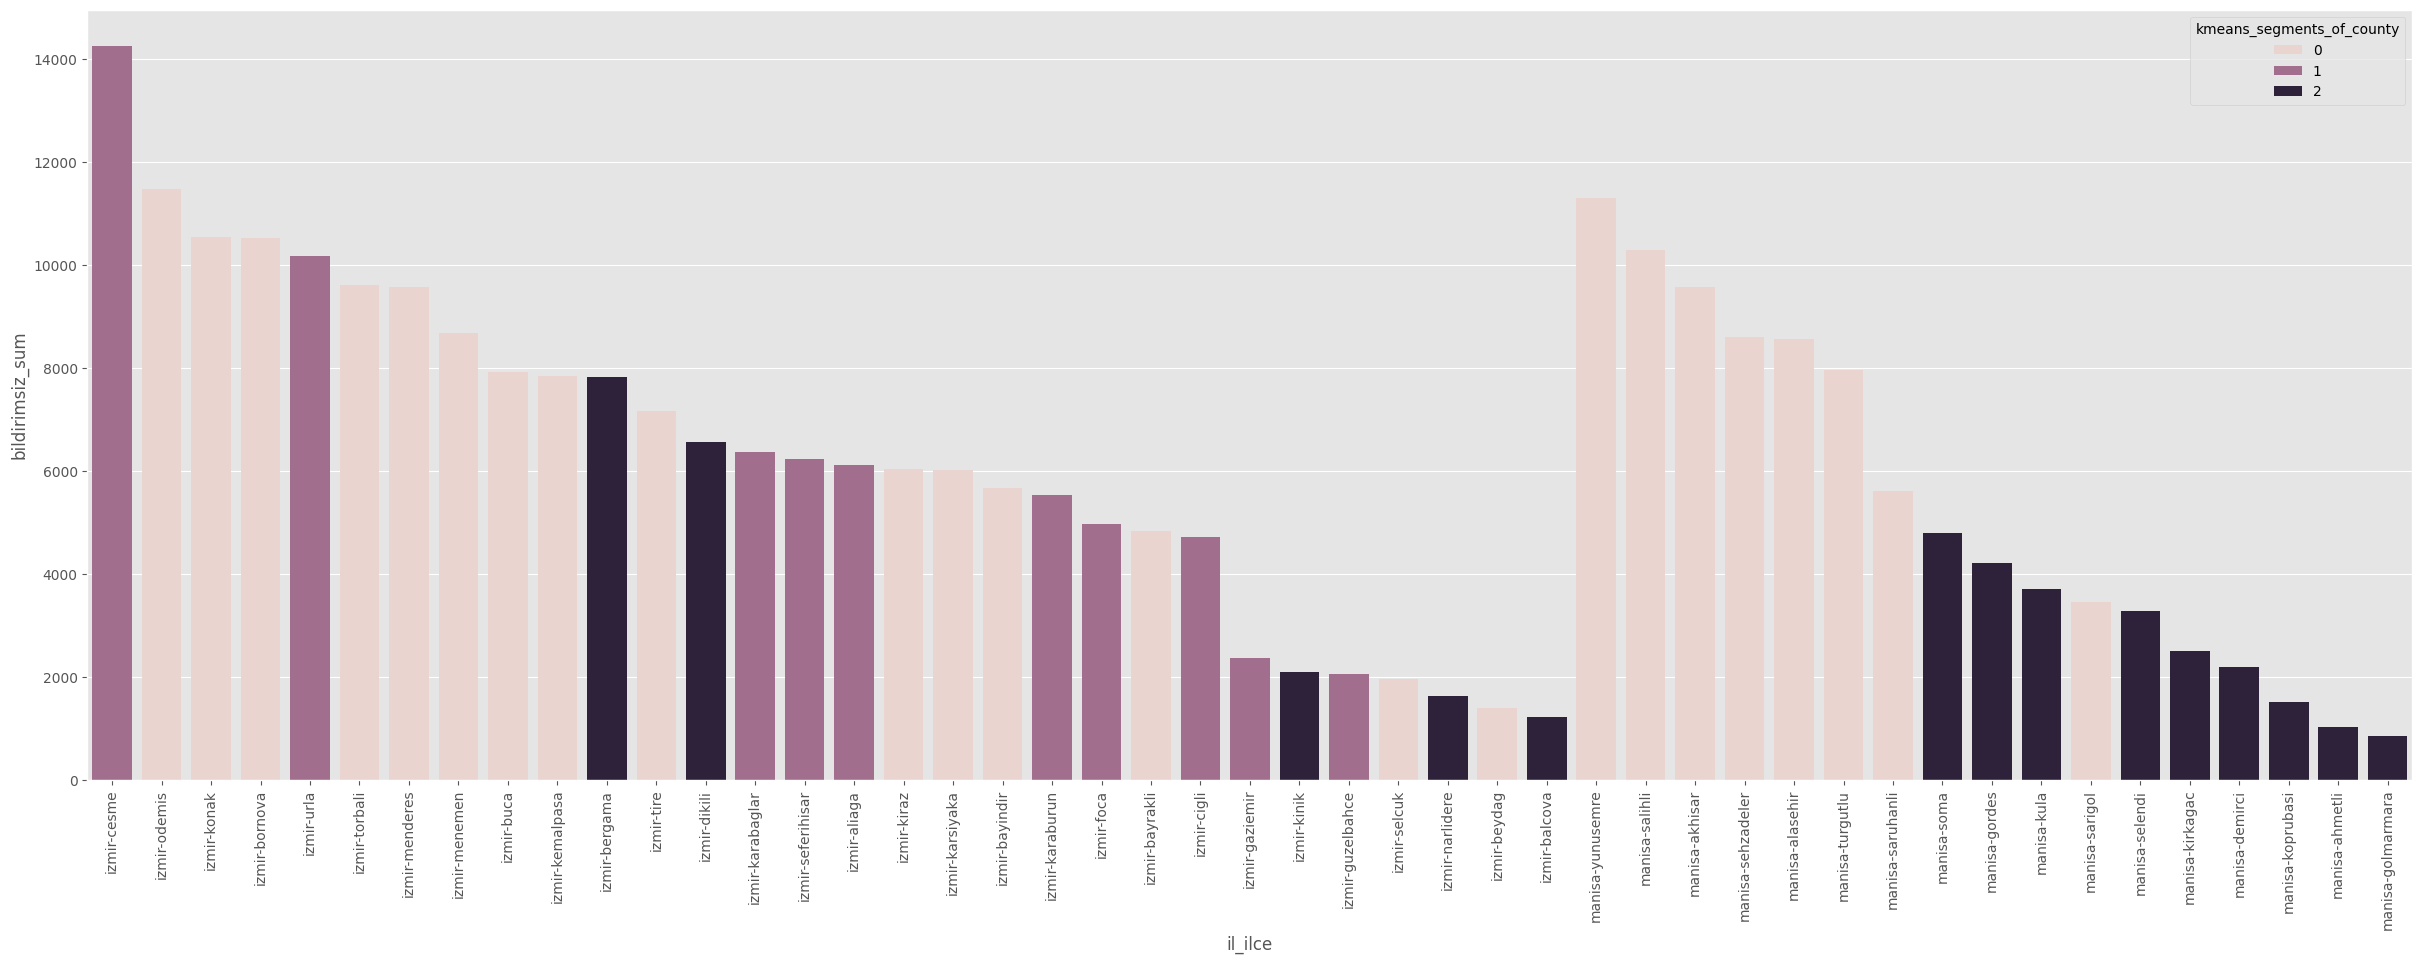

In [61]:
plt.figure(figsize=(30,10))
sns.barplot(x="il_ilce",y="bildirimsiz_sum",data=segment_kmeans_df,hue="kmeans_segments_of_county")
plt.xticks(rotation=90)
plt.show()

**Time series özellikleri**

In [62]:
temp_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
temp_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]

time_series_train_group = temp_train.groupby("tarih")[["bildirimsiz_sum","bildirimli_sum"]].sum().reset_index()
time_series_train_group["tarih"] = pd.to_datetime(time_series_train_group["tarih"])
time_series_train_group.head()

,tarih,bildirimsiz_sum,bildirimli_sum
0,2021-01-01,220.0,4
1,2021-01-02,631.5,31
2,2021-01-03,212.0,44
3,2021-01-04,236.0,25
4,2021-01-05,190.0,4


In [63]:
time_series_train_group["bildirimsiz_rolling_1_year"] = time_series_train_group["bildirimsiz_sum"].rolling(window=365).mean()
time_series_train_group["bildirimsiz_diff_1_year"] = time_series_train_group["bildirimsiz_sum"].diff(periods=365)
seasonal_decomposed = seasonal_decompose(time_series_train_group["bildirimsiz_sum"], period=365)
time_series_train_group["bildirimsiz_seasonal_1_year"] = seasonal_decomposed.seasonal


time_series_train_group["bildirimli_rolling_1_year"] = time_series_train_group["bildirimli_sum"].rolling(window=365).mean()
time_series_train_group["bildirimli_diff_1_year"] = time_series_train_group["bildirimli_sum"].diff(periods=365)
seasonal_decomposed = seasonal_decompose(time_series_train_group["bildirimli_sum"], period=365)
time_series_train_group["bildirimli_seasonal_1_year"] = seasonal_decomposed.seasonal


time_series_train_group.bfill(inplace=True)
time_series_train_group.ffill(inplace=True)
time_series_train_group.drop(["bildirimsiz_sum","bildirimli_sum"],inplace=True,axis=1)

time_series_train_group.head()

,tarih,bildirimsiz_rolling_1_year,bildirimsiz_diff_1_year,bildirimsiz_seasonal_1_year,bildirimli_rolling_1_year,bildirimli_diff_1_year,bildirimli_seasonal_1_year
0,2021-01-01,283.917808,-28.0,-82.201439,26.59726,-2.0,-27.422881
1,2021-01-02,283.917808,-28.0,-27.102809,26.59726,-2.0,-9.422881
2,2021-01-03,283.917808,-28.0,-67.456918,26.59726,-2.0,-4.444799
3,2021-01-04,283.917808,-28.0,228.156781,26.59726,-2.0,19.030544
4,2021-01-05,283.917808,-28.0,-78.387055,26.59726,-2.0,-27.995484


**Planlı bakım sayısı yıllar içinde artarken plansız bakım sayısı azalmaktadır. Buda planlı bakımların beklenen etkiyi gösterdiğini göstermektedir. Fakat bir süre sonra daha fazla iyileşme sağlanamadığından grafikler paralen gitmektedir. Bu sefer planlı bakımların sayısının da azalmaya başladığı görülmektedir.**

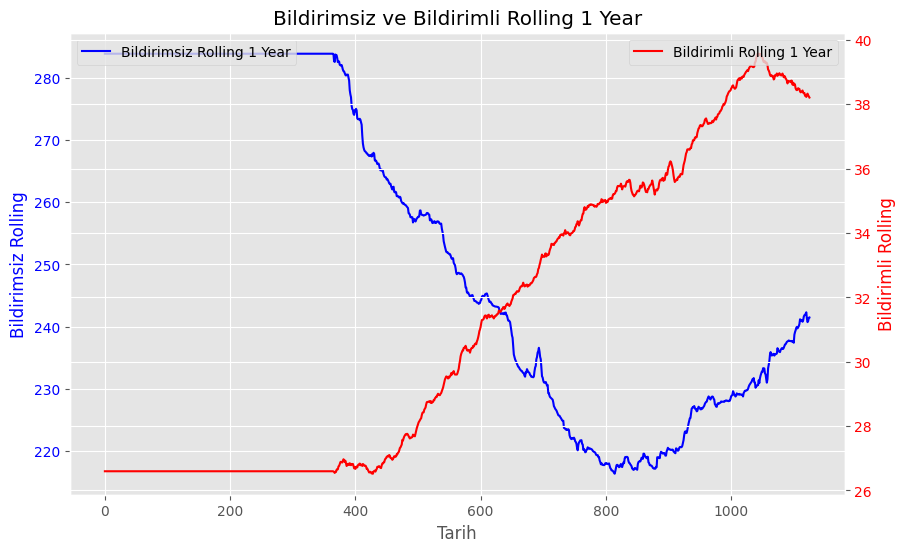

In [64]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(time_series_train_group.index, time_series_train_group["bildirimsiz_rolling_1_year"], label="Bildirimsiz Rolling 1 Year", color="blue")
ax1.set_xlabel("Tarih")
ax1.set_ylabel("Bildirimsiz Rolling", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(time_series_train_group.index, time_series_train_group["bildirimli_rolling_1_year"], label="Bildirimli Rolling 1 Year", color="red")
ax2.set_ylabel("Bildirimli Rolling", color="red")
ax2.tick_params(axis='y', labelcolor="red")
ax2.legend(loc="upper right")

plt.title("Bildirimsiz ve Bildirimli Rolling 1 Year")

plt.show()

**Test grup oluşturulması ve tahminlerin test setine eklenmesi**

In [65]:
train_feature_list=time_series_train_group.loc[:,time_series_train_group.columns.str.contains("bildirimsiz|bildirimli")].columns.to_list()
train_feature_list

['bildirimsiz_rolling_1_year',
 'bildirimsiz_diff_1_year',
 'bildirimsiz_seasonal_1_year',
 'bildirimli_rolling_1_year',
 'bildirimli_diff_1_year',
 'bildirimli_seasonal_1_year']

In [66]:
time_series_test_group = temp_test.groupby("tarih")[["bildirimsiz_sum","bildirimli_sum"]].sum().reset_index()
for feature in train_feature_list:
    time_series_test_group[feature] = np.nan
time_series_test_group["tarih"] = pd.to_datetime(time_series_test_group["tarih"])

time_series_test_group.drop(["bildirimsiz_sum","bildirimli_sum"],inplace=True,axis=1)
time_series_test_group.head()

,tarih,bildirimsiz_rolling_1_year,bildirimsiz_diff_1_year,bildirimsiz_seasonal_1_year,bildirimli_rolling_1_year,bildirimli_diff_1_year,bildirimli_seasonal_1_year
0,2024-02-01,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-02,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-02-04,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-02-05,NaN,NaN,NaN,NaN,NaN,NaN


**Burada prophet kullanılarak çıkarılan değişkenler tahmin edilmiştir.**

In [67]:
def predict_ts_features_and_write_to_test_df(test_df: pd.DataFrame, train_df: pd.DataFrame, feature_list: list, date_col_name: str):
    
    test_df_copy = test_df.copy()
    for feature in feature_list:
        df = train_df[[date_col_name, feature]].copy()
        df.rename(columns={date_col_name: "ds", feature: "y"}, inplace=True)
        model = Prophet(
            changepoint_prior_scale=0.01,   # Trendin esnekliği (artırabilirsiniz)
            seasonality_prior_scale=20.0,  # Mevsimsellik esnekliği
            holidays_prior_scale=10.0,     # Tatil etkilerinin esnekliği
            seasonality_mode='additive',   # Mevsimsellik modu
            n_changepoints=25,             # Trend değişim noktaları (artırabilirsiniz)
            yearly_seasonality=True,       # Yıllık mevsimsellik
        )
        model.fit(df)
        future = model.make_future_dataframe(periods=len(test_df))
        forecast = model.predict(future)
        #hareketli ortalamasını alarak pürüzsüzleştiriyoruz. Bu şekilde, ani düşüşlerin etkisini azaltıyoruz ve tahminlerimizin daha istikrarlı hale gelmesini sağlıyoruz.
        forecast['yhat'] = forecast['yhat'].rolling(window=1, min_periods=1).mean()
        test_df_copy.loc[:, feature] = forecast["yhat"].values[-len(test_df):]
    print("Features have been predicted and written to the test DataFrame!")
    print("---------------------")
    return test_df_copy

In [68]:
time_series_test_group = predict_ts_features_and_write_to_test_df(time_series_test_group,time_series_train_group,train_feature_list, "tarih")
time_series_test_group.head()


21:05:43 - cmdstanpy - INFO - Chain [1] start processing
21:05:43 - cmdstanpy - INFO - Chain [1] done processing
21:05:43 - cmdstanpy - INFO - Chain [1] start processing
21:05:43 - cmdstanpy - INFO - Chain [1] done processing
21:05:44 - cmdstanpy - INFO - Chain [1] start processing
21:05:44 - cmdstanpy - INFO - Chain [1] done processing
21:05:44 - cmdstanpy - INFO - Chain [1] start processing
21:05:45 - cmdstanpy - INFO - Chain [1] done processing
21:05:45 - cmdstanpy - INFO - Chain [1] start processing
21:05:45 - cmdstanpy - INFO - Chain [1] done processing
21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing


Features have been predicted and written to the test DataFrame!
---------------------


,tarih,bildirimsiz_rolling_1_year,bildirimsiz_diff_1_year,bildirimsiz_seasonal_1_year,bildirimli_rolling_1_year,bildirimli_diff_1_year,bildirimli_seasonal_1_year
0,2024-02-01,240.412373,-20.313488,3.120006,38.279450,11.338538,-1.254378
1,2024-02-02,240.393732,-14.835789,-4.553081,38.266496,5.474532,-2.026739
2,2024-02-03,240.335111,-27.440860,-13.872958,38.249520,4.082188,-1.241919
3,2024-02-04,240.278699,-26.638981,-17.978902,38.238391,6.416556,-1.681880
4,2024-02-05,240.289669,-2.400773,-18.510414,38.226036,6.204806,-1.637861


In [69]:
def plot_all_feature_predictions(train_df:pd.DataFrame, test_df:pd.DataFrame, feature_list:list, date_col:str):
    for feature in feature_list:
        plt.figure(figsize=(10, 6))
        plt.plot(train_df[date_col], train_df[feature], label=feature)
        plt.plot(test_df[date_col], test_df[feature], label=feature)
        plt.title("Train ve Tahmin Edilen Değerlerin Grafiksel Karşılaştırması")
        plt.xlabel(date_col)
        plt.ylabel(feature)
        plt.legend()
        plt.grid(True)
        plt.show()

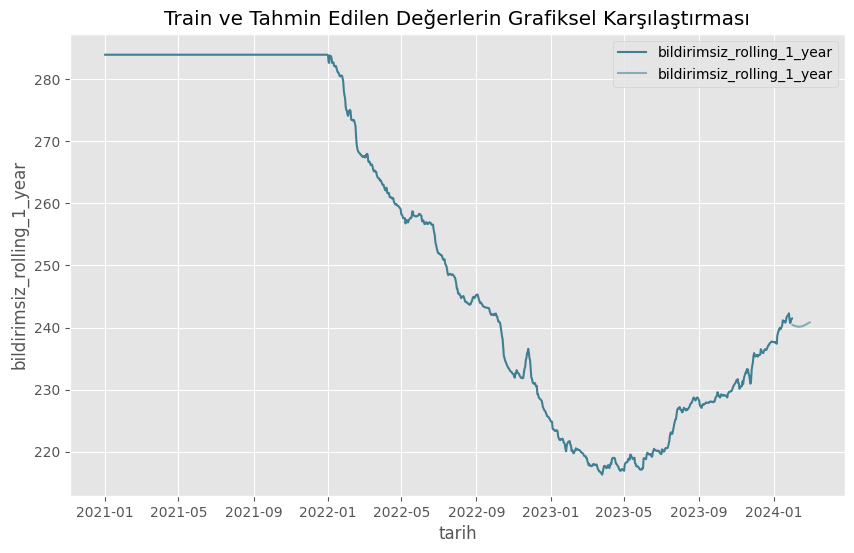

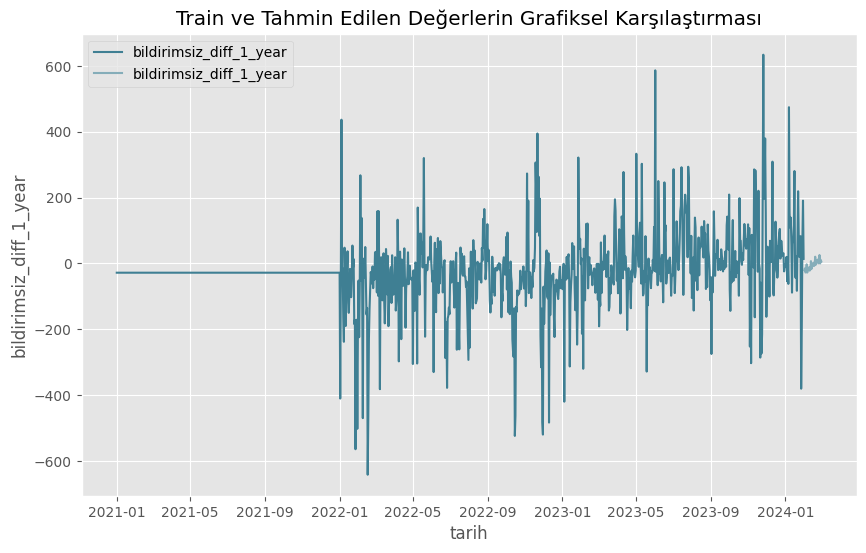

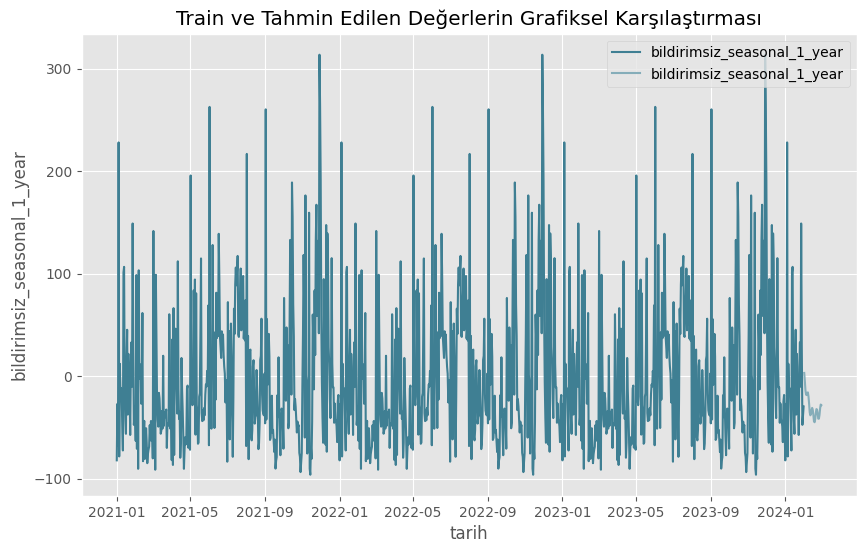

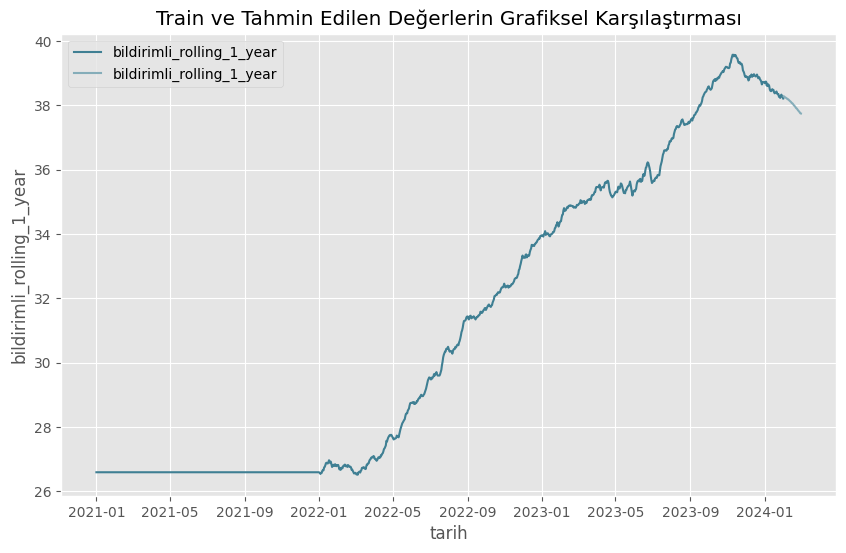

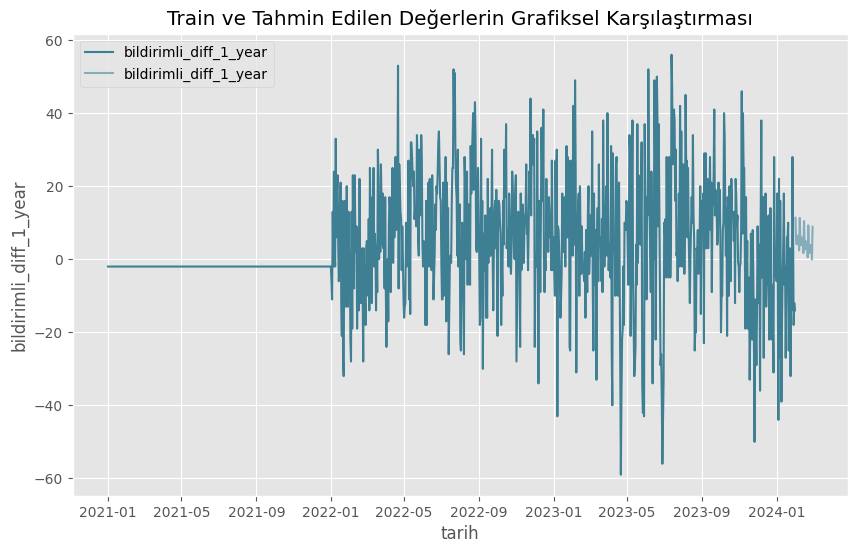

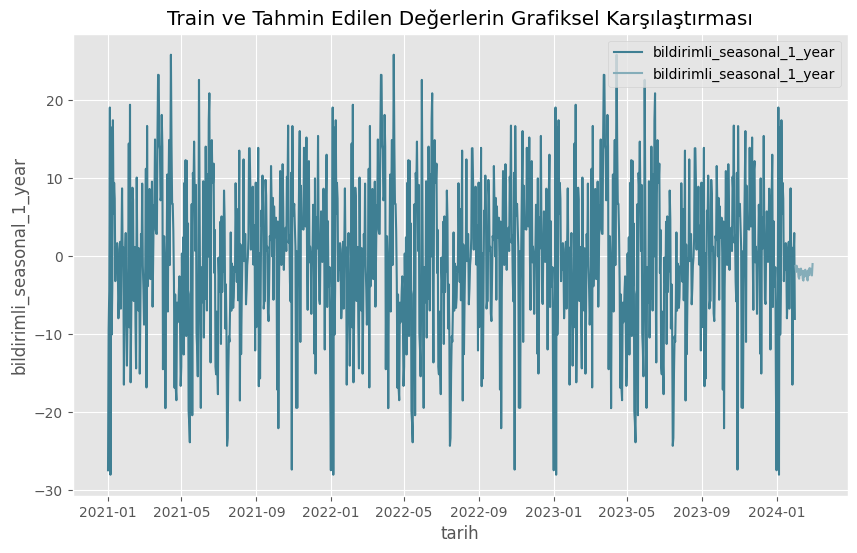

In [70]:
plot_all_feature_predictions(time_series_train_group,time_series_test_group,train_feature_list,"tarih")

**Verilerin tekrar birleştirilmesi**

In [71]:
time_series_train_group["tarih"] = time_series_train_group["tarih"].dt.strftime("%Y-%m-%d")
time_series_test_group["tarih"] = time_series_test_group["tarih"].dt.strftime("%Y-%m-%d")
temp_train = pd.merge(temp_train,time_series_train_group,how="left",on="tarih")
temp_test = pd.merge(temp_test,time_series_test_group,how="left",on="tarih")
train_test_concat=pd.concat([temp_train,temp_test],axis=0)

**Korelasyon Analizi**

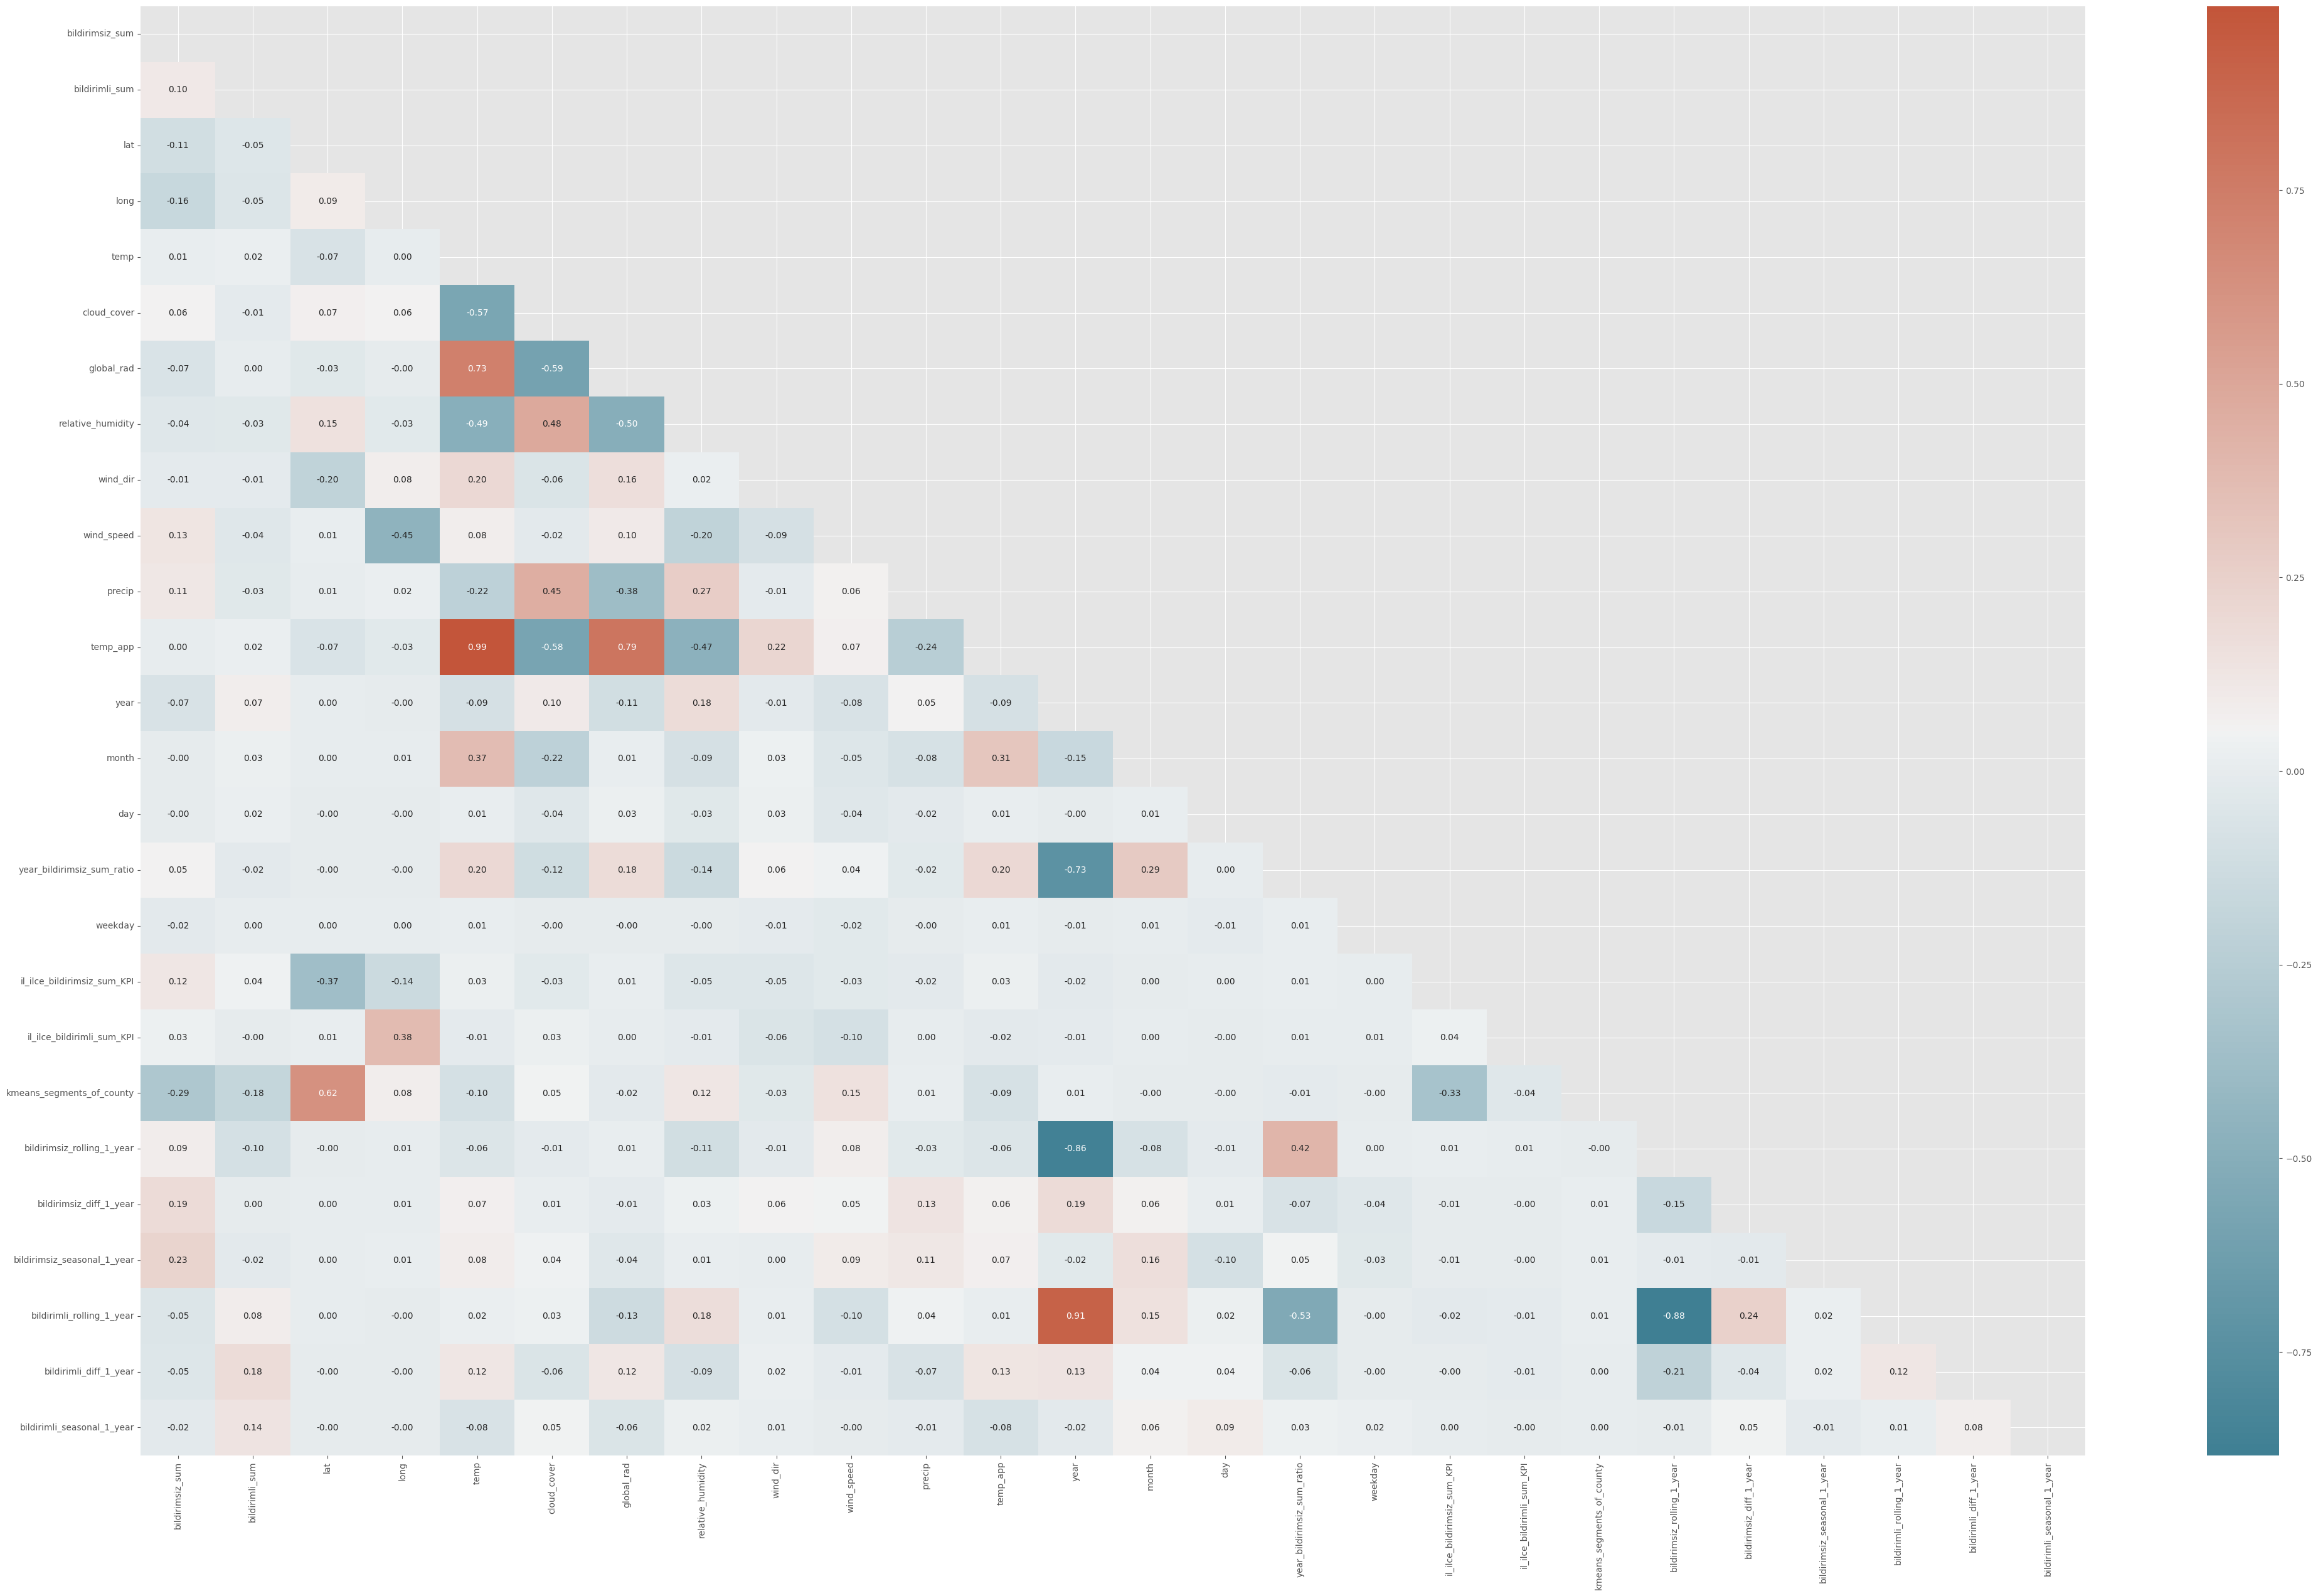

In [72]:
plt.figure(figsize=(50, 30))
num_variables = train_test_concat.select_dtypes(exclude=["object","category"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

**Multicollinearity probleminden dolayı 0.75 üzeri korelasyonlu olan değişkenlerin 1 tanesi overfittinge yol açmaması için veri setinden çıkarılmıştır. Bu değişkenler;**
- temp ve temp_app: 0.99 korelasyon var, temp_app çıkarıldı. 
- year ile pek çok değişken arasında yüksek korelasyon olduğundan year değişkenide çıkarılmıştır.
- bildirimli_rolling_1_year ile bildirimsiz_rolling_1_year arasında -0.88 korelasyon var bildirimli_rolling_1_year çıkarılmıştır.

In [73]:
train_test_concat.drop(["temp_app","year","bildirimli_rolling_1_year"],axis=1,inplace=True)

**Veri Ön İşleme**
- Bayram flag one hot encoding işlemi

In [74]:
bayram_one_hot = pd.get_dummies(train_test_concat["flag"],drop_first=True).astype(int)
train_test_concat.drop("flag", axis=1,inplace=True)
train_test_concat=pd.concat([train_test_concat,bayram_one_hot], axis=1)

- İl İlçe alan büyüklüklerine göre label encoding işlemi

In [75]:
train_test_concat["il_ilce"].nunique()

47

- İl ilçe label encoding işlemi.

In [76]:
data = {
    "ilce": ["izmir-aliaga", "izmir-balcova", "izmir-bayindir", "izmir-bayrakli", "izmir-bergama", "izmir-beydag", "izmir-bornova", "izmir-buca", "izmir-cesme", "izmir-cigli", "izmir-dikili", "izmir-foca", "izmir-gaziemir", "izmir-guzelbahce", "izmir-karabaglar", "izmir-karaburun", "izmir-karsiyaka", "izmir-kemalpasa", "izmir-kinik", "izmir-kiraz", "izmir-konak", "izmir-menderes", "izmir-menemen", "izmir-narlidere", "izmir-odemis", "izmir-seferihisar", "izmir-selcuk", "izmir-tire", "izmir-torbali", "izmir-urla", "manisa-ahmetli", "manisa-akhisar", "manisa-alasehir", "manisa-demirci", "manisa-golmarmara", "manisa-gordes", "manisa-kirkagac", "manisa-koprubasi", "manisa-kula", "manisa-salihli", "manisa-sarigol", "manisa-saruhanli", "manisa-selendi", "manisa-soma", "manisa-sehzadeler", "manisa-turgutlu", "manisa-yunusemre"],
    "alanı_km2": [379, 16, 548, 30, 1544, 172, 220, 178, 285, 139, 534, 251, 70, 77, 89, 421, 51, 681, 479, 573, 24, 777, 573, 50, 1019, 375, 317, 716, 577, 727, 227, 1645, 971, 1321, 310, 902, 541, 447, 981, 1359, 432, 771, 726, 820, 515, 549, 823]
}
il_ilce_df = pd.DataFrame(data).reset_index(drop=True).sort_values("alanı_km2")
il_ilce_df.head()

,ilce,alanı_km2
1,izmir-balcova,16
20,izmir-konak,24
3,izmir-bayrakli,30
23,izmir-narlidere,50
16,izmir-karsiyaka,51


In [77]:
order_cols = il_ilce_df["ilce"].to_list()
train_test_concat["il_ilce_label_enc"] = pd.Categorical(train_test_concat["il_ilce"],categories=order_cols,ordered=True)
train_test_concat["il_ilce_label_enc"] = train_test_concat["il_ilce_label_enc"].cat.codes
train_test_concat["il_ilce_label_enc"].nunique()

47

**Korelasyon Kontrol**

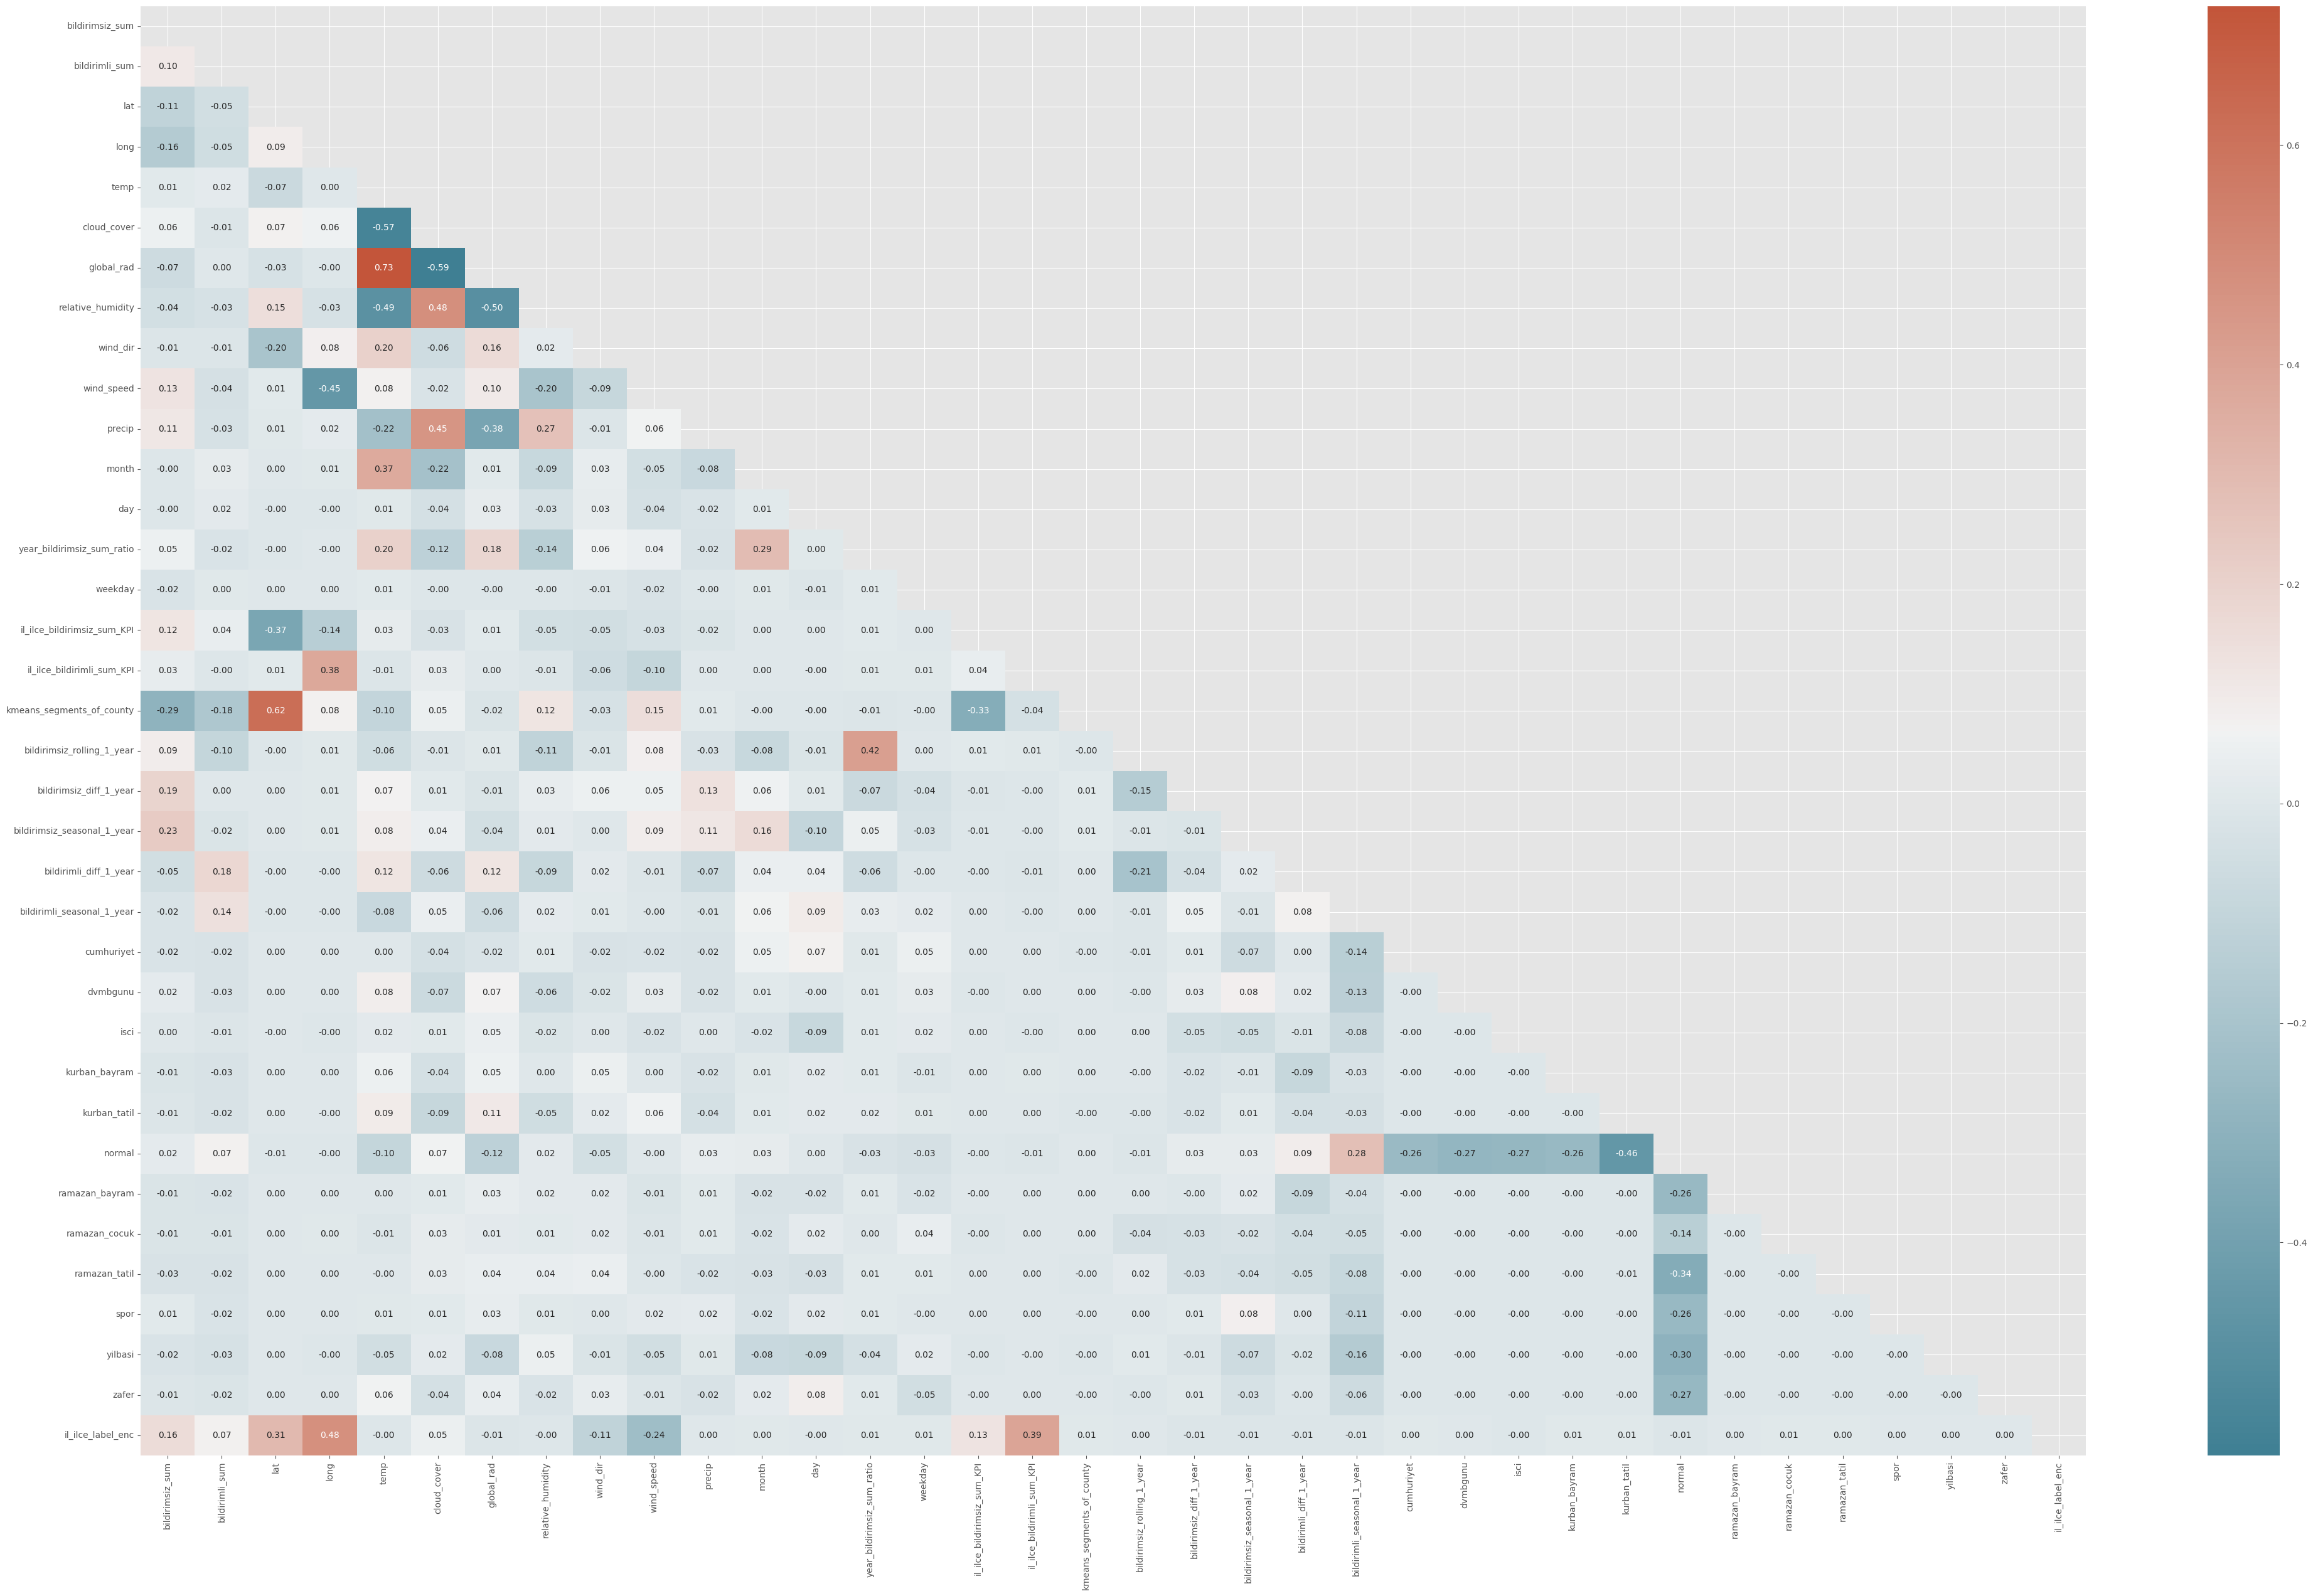

In [78]:
plt.figure(figsize=(50, 30))
num_variables = train_test_concat.select_dtypes(exclude=["object","category"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

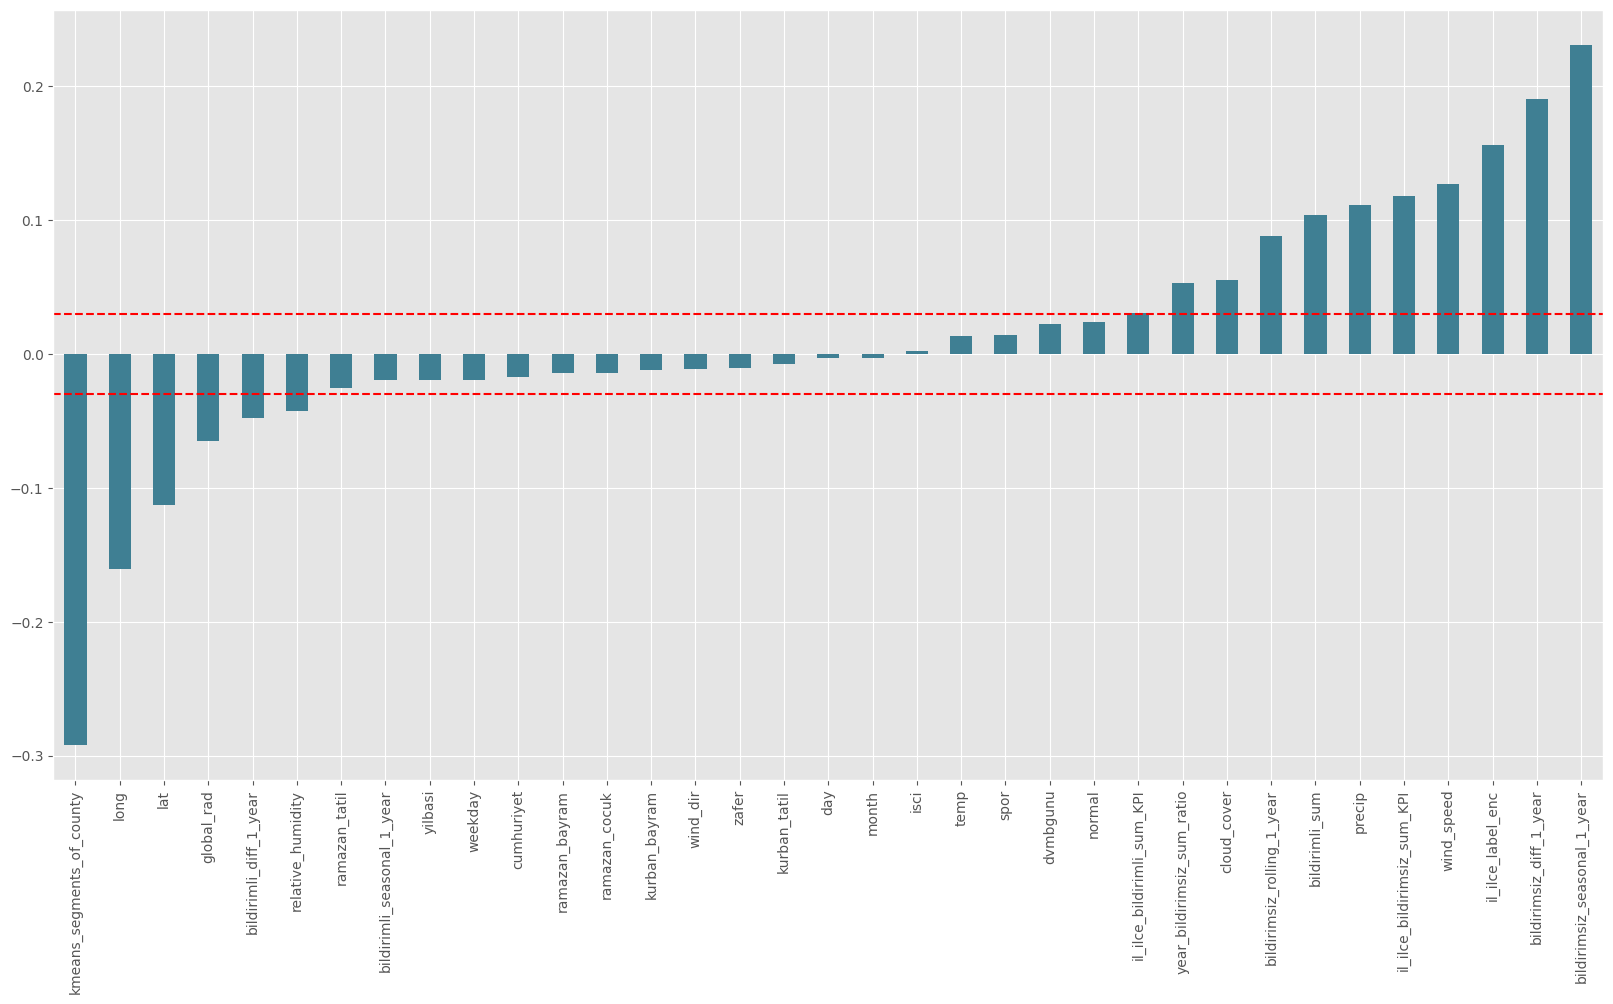

In [79]:
plt.figure(figsize=(20, 10))
tri_df["bildirimsiz_sum"].drop("bildirimsiz_sum").sort_values().plot(kind="bar")
plt.axhline(0.03, color ="red",linestyle ='--')
plt.axhline(-0.03, color='red',linestyle='--')
plt.show()

In [80]:
cor_target = abs(tri_df["bildirimsiz_sum"])
cor_target.drop("bildirimsiz_sum",inplace=True,axis=0)
correlated_features  = cor_target[cor_target >=0.03]
print("Toplam sayısal özellik sayısı:",len(train_test_concat.select_dtypes(exclude="object").columns))
print("Korelasyonlu özellik sayısı:",len(correlated_features))

Toplam sayısal özellik sayısı: 36
Korelasyonlu özellik sayısı: 17


**Model Oluşturma ve Değerlendirme**

**Model eğitim ve değerlendirme için kullanılacak fonksiyonun tanımlanması**
- Tüm model eğitimi ve değerlendirme süreci, işleri kolay ve hatasız hale getirmek, zaman kazanmak, denemeler yapmak için fonksiyona dönüştürülmüştür. Bu fonksiyon, modeli, bölünmüş verileri, çapraz doğrulama stratejisini, model değerlendirmede kullanılacak metriği  parametre olarak alır ve eğitilmiş modeli, eğitim ve doğrulama skorlarını içeren dataframe'i, son test skorunu ve test seti üzerindeki tahminleri döndürür. Plot parametresi aynı zamanda True olarak belirtilirse eğitim ve doğrulama sonuçlarını çizer. Eğitim verilerine çapraz doğrulama uygulamak, model değerlendirme aşamasında sıklıkla tercih edilen bir yöntemdir. Bu sayede modelin eğitim, doğrulama ve test seti üzerindeki sonuçlarını karşılaştırarak aşırı uyum ve yetersiz uyum durumlarını daha kolay gözlemleyebilir ve hiperparametreleri bu sonuçlara göre ayarlayabiliriz.
- Occams' razor prensibine göre basit modelden karmaşık modele gidilmiştir. Mae metriğine ilave olarak gelişmeyi izlemek için r2 metriği kullanılmıştır.

In [81]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, score_func, cv_type, plot=True, use_rmse=False):
    """
    This function uses cross-validation to evaluate the performance of a model.
    It allows comparison by calculating training score, validation score, and test score separately.
    First, it performs cross-validation, then trains the model with the entire training set from scratch to calculate the test score.
    This enables a better evaluation of model performance and detection of issues such as overfitting or underfitting.

    Parameters:
    model: the model to be trained.
    X_train: pandas.DataFrame, the split training dataset.
    y_train: pandas.Series, the target variable of the training dataset.
    X_test: pandas.DataFrame, the split test dataset.
    y_test: pandas.Series, the target variable of the test dataset.
    score_func: function, evaluation metric. For example, mean_squared_error, mean_absolute_error, etc.
    cv_type: cross-validation strategy. For example, KFold, StratifiedKFold, etc.
    plot: bool, optional (default=True) If True, plots the training and validation scores.
    use_rmse: bool, optional (default=False) If the metric function is mean_squared_error, set to True to calculate Root Mean Squared Error.

    Returns:
    model: trained model.
    final_test_score: float, metric score obtained on the test set.
    scores_df: pandas.DataFrame, dataframe containing calculated training and validation scores.
    y_pred_test: pandas.Series, predictions on the test set.
    """

    
    # score list initialization.
    train_scores = []
    validation_scores = []
    score_per_fold = []
    fold = 1

    # cross validation stage for overfitting , underfitting detection
    for train_index, test_index in cv_type.split(X_train, y_train):
        X_train_cv, X_validation_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_validation_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # model fitting on train set
        model.fit(X_train_cv, y_train_cv)
        y_pred_train = model.predict(X_train_cv)
        y_pred_validation = model.predict(X_validation_cv)
        
        # evaluation of train score
        train_score = score_func(y_train_cv, y_pred_train)
        # evaluation of validation score
        validation_score = score_func(y_validation_cv, y_pred_validation)

       
       #if mean_squared_error score func use_rmse=True 
        if use_rmse and score_func.__name__ == "mean_squared_error":
            train_score = np.sqrt(train_score)
            validation_score = np.sqrt(validation_score)
            score_name = "root_mean_squared_error"
        else:
            train_score = train_score
            validation_score = validation_score
            score_name = score_func.__name__
        

   
        train_scores.append(train_score)
        validation_scores.append(validation_score)

        # scores per fold
        print(f"{fold}. Fold train_{score_name}: {train_score:.2f}")
        print(f"{fold}. Fold validasyon_{score_name}: {validation_score:.2f}")

        fold += 1
  
        score_per_fold.append(fold)

    print("Cross validation stage has been complated! Model is started to training...")

    # Çapraz doğrulama aşaması tamamlandıktan sonra. Model tüm eğitim seti ile tekrar eğitilir.
    model.fit(X_train, y_train)
    print("*******************************************")
    print("Model training has been complated!")
    print("*******************************************")

    # test seti üzerinden tahmin yapılması.
    y_pred_test = model.predict(X_test)
    
    # use_rmse=True calculate RMSE 
    if use_rmse and score_func.__name__ == "mean_squared_error":
        final_test_score = np.sqrt(score_func(y_test , y_pred_test))
        score_name = "root_mean_squared_error"
    else:
        final_test_score = score_func(y_test , y_pred_test)
        score_name = score_func.__name__


    # saves scores in dictionary.
    scores_dict = {
    "fold": range(1, len(score_per_fold) + 1),
    f"train_{score_name}": train_scores,
    f"validation_{score_name}": validation_scores
    }

    # df for plotting
    scores_df = pd.DataFrame(scores_dict)

    
    # diff % of validation score according to training score 
    percentage_difference_train_valid = ((np.mean(validation_scores) - np.mean(train_scores)) / np.mean(train_scores)) * 100

    # diff % of final score according to training score 
    percentage_difference_train_test = ((final_test_score - np.mean(train_scores)) / np.mean(train_scores)) * 100

  
    print(f"Average train_{score_name} result: {np.mean(train_scores):.2f}")
    print(f"Average validation_{score_name} sonucu: {np.mean(validation_scores):.2f}")
    print(f"Test_{score_name} result: {final_test_score:.2f}")
    print(f'Validation percentage according to train:%{percentage_difference_train_valid:.2f}')
    print(f'Final test percentage according to train:%{percentage_difference_train_test:.2f}')
    print("*******************************************")


    if plot:
        sns.lineplot(data=scores_df, x="fold", y=f"train_{score_name}", marker="o", label=f"train_{score_name}")
        sns.lineplot(data=scores_df, x="fold", y=f"validation_{score_name}", marker="v", label=f"validation_{score_name}")
        plt.xlabel("Katman")
        plt.ylabel(f"{score_name}")
        plt.title(f"Each fold {score_name} score")
        plt.legend()
        plt.show()

    return  model, final_test_score, scores_df, y_pred_test

**Verilerin Ayrılması**

In [82]:
new_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
new_train["bildirimsiz_sum"] = new_train["bildirimsiz_sum"].astype(int)
new_train["tarih"] = pd.to_datetime(new_train["tarih"])
new_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]
new_test["tarih"] = pd.to_datetime(new_test["tarih"])

In [83]:
new_train.shape

(48148, 41)

In [84]:
new_test.shape

(1363, 41)

**Verilerin Eğitim ve Test Olarak ayrılması**
- Model aşamasında metriklerimizi hesaplamak için veri setini eğitim ve test diye bölmek yaygın bir uygulamadır. Burada verinin %20'si test seti için ayrılmıştır.

In [85]:
target = "bildirimsiz_sum"
columns_that_will_not_used = [target,"tarih","il_ilce","il","ilce","unique_id","day","relative_humidity",
                              'bildirimli_seasonal_1_year',"bildirimsiz_pct_change_1_year","bildirimsiz_ratio_per_city_county","bildirimsiz_seasonal_1_year",
                              "day_bildirimsiz_sum_ratio","bildirimli_diff_1_year"] 

feature_columns = [col for col in new_train.columns if col not in columns_that_will_not_used]
X = new_train[feature_columns]
y= new_train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [86]:
X.columns

Index(['bildirimli_sum', 'lat', 'long', 'temp', 'cloud_cover', 'global_rad',
       'wind_dir', 'wind_speed', 'precip', 'month',
       'year_bildirimsiz_sum_ratio', 'weekday', 'il_ilce_bildirimsiz_sum_KPI',
       'il_ilce_bildirimli_sum_KPI', 'kmeans_segments_of_county',
       'bildirimsiz_rolling_1_year', 'bildirimsiz_diff_1_year', 'cumhuriyet',
       'dvmbgunu', 'isci', 'kurban_bayram', 'kurban_tatil', 'normal',
       'ramazan_bayram', 'ramazan_cocuk', 'ramazan_tatil', 'spor', 'yilbasi',
       'zafer', 'il_ilce_label_enc'],
      dtype='object')

**Linear Regression Modeli**
- Modelin daha iyi performans göstermesi için yüksek derecede sağa çarpık verilerin ölçeklendirilmesi gerekebilir. Bunun için pipeline içerisinde RobustScaler kullanılmıştır. 
- RobustScaler, aykırı değerlerin etkisini azaltmak için medyan ve yüzdelik aralıkları kullanarak çalışır. Çarpık değişkenlerin olduğu veri setlerinde iyi performans gösterebilir.

1. Fold train_mean_absolute_error: 3.14
1. Fold validasyon_mean_absolute_error: 3.13
2. Fold train_mean_absolute_error: 3.15
2. Fold validasyon_mean_absolute_error: 3.08
3. Fold train_mean_absolute_error: 3.14
3. Fold validasyon_mean_absolute_error: 3.10
4. Fold train_mean_absolute_error: 3.14
4. Fold validasyon_mean_absolute_error: 3.12
5. Fold train_mean_absolute_error: 3.13
5. Fold validasyon_mean_absolute_error: 3.18
6. Fold train_mean_absolute_error: 3.13
6. Fold validasyon_mean_absolute_error: 3.17
7. Fold train_mean_absolute_error: 3.14
7. Fold validasyon_mean_absolute_error: 3.14
8. Fold train_mean_absolute_error: 3.13
8. Fold validasyon_mean_absolute_error: 3.19
9. Fold train_mean_absolute_error: 3.13
9. Fold validasyon_mean_absolute_error: 3.17
10. Fold train_mean_absolute_error: 3.14
10. Fold validasyon_mean_absolute_error: 3.11
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been compl

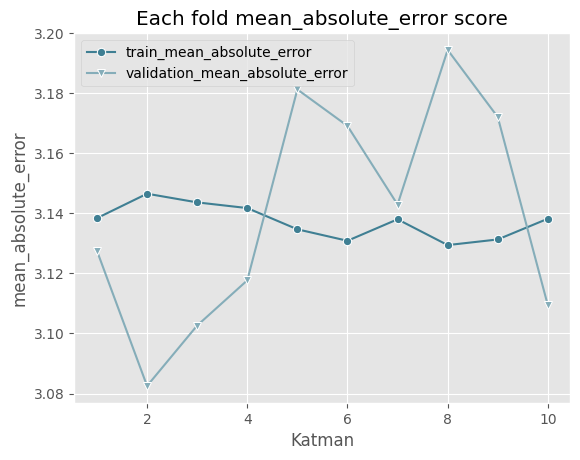

In [87]:
lr = LinearRegression()

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", lr)
])

kf = KFold(n_splits=10,shuffle=True,random_state=42)
lr_model, lr_final_test_mae_score, lr_mae_scores_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test, mean_absolute_error, kf, plot=True, use_rmse=False)

1. Fold train_r2_score: 0.25
1. Fold validasyon_r2_score: 0.25
2. Fold train_r2_score: 0.25
2. Fold validasyon_r2_score: 0.25
3. Fold train_r2_score: 0.25
3. Fold validasyon_r2_score: 0.25
4. Fold train_r2_score: 0.26
4. Fold validasyon_r2_score: 0.24
5. Fold train_r2_score: 0.25
5. Fold validasyon_r2_score: 0.25
6. Fold train_r2_score: 0.25
6. Fold validasyon_r2_score: 0.26
7. Fold train_r2_score: 0.25
7. Fold validasyon_r2_score: 0.25
8. Fold train_r2_score: 0.25
8. Fold validasyon_r2_score: 0.25
9. Fold train_r2_score: 0.25
9. Fold validasyon_r2_score: 0.26
10. Fold train_r2_score: 0.25
10. Fold validasyon_r2_score: 0.26
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been complated!
*******************************************
Average train_r2_score result: 0.25
Average validation_r2_score sonucu: 0.25
Test_r2_score result: 0.27
Validation percentage according to train:%-0.64
Final test percent

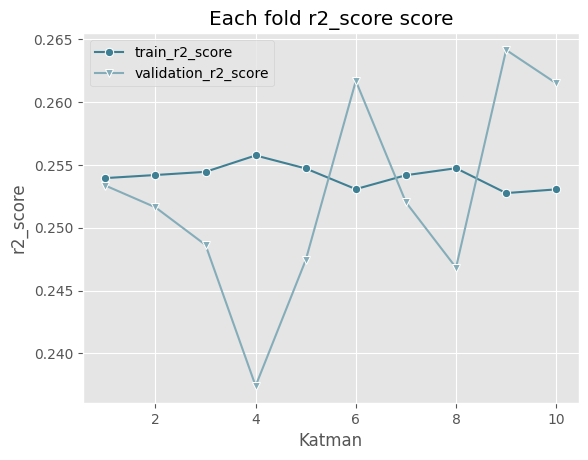

In [88]:
lr = LinearRegression()

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", lr)
])

kf = KFold(n_splits=10,shuffle=True,random_state=42)
_ , lr_final_test_r2_score, lr_r2_scores_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test, r2_score, kf, plot=True, use_rmse=False)

**Linear Regression Özellik Seçimi**


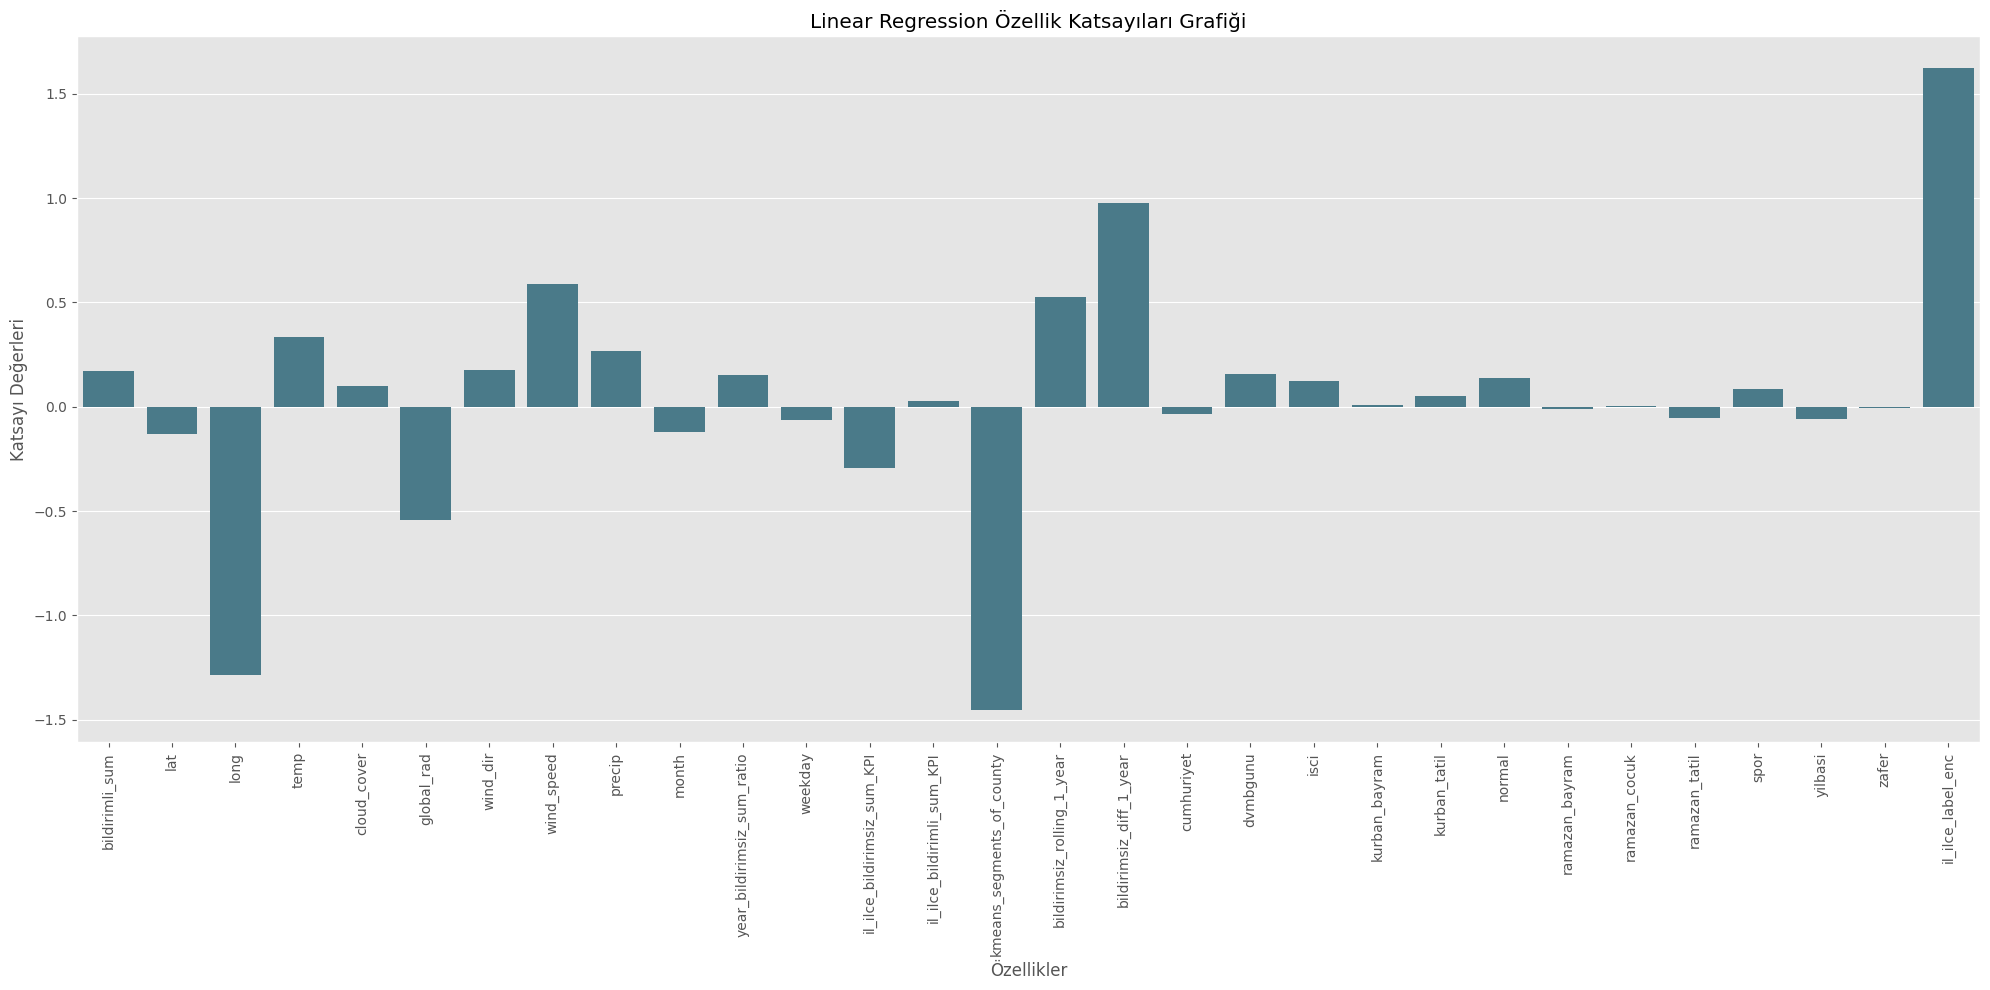

In [89]:
coef_values = lr_model.named_steps["regressor"].coef_
columns = X_train.columns
plt.figure(figsize=(20,10))
sns.barplot(x=columns, y=coef_values)
plt.xlabel("Özellikler")
plt.ylabel("Katsayı Değerleri")
plt.title("Linear Regression Özellik Katsayıları Grafiği")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**XgBoostRegressor Modeli**
- Model ağaç tabanlı olduğundan karmaşık ve çarpık verilerde iyi performans gösterir bu nedenle ölçekleme uygulanmamıştır.

**Hiperparametre Optimizasyonu**
- Bayesyen hiperparametre ayarlama, makine öğrenimi modellerindeki hiperparametreleri optimize etmek için bayesyen istatistiklerini kullanır. 
Bu yöntem, en iyi hiperparametre değerlerini tahmin etmek için bir olasılık dağılımını günceller ve modelin performansını artırmayı amaçlar.

In [142]:
# space = {
#     'learning_rate': hp.loguniform('learning_rate', -5, 0),  
#     'n_estimators': hp.quniform('n_estimators', 95, 500, 1),
#     'max_depth': hp.choice('max_depth', range(3, 15)),  
#     'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1), 
#     'subsample': hp.uniform('subsample', 0.2, 1), 
#     'gamma': hp.uniform('gamma', 0, 1), 
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1), 
#     'reg_alpha': hp.quniform('reg_alpha', 0, 80, 1), 
#     'reg_lambda': hp.uniform('reg_lambda', 0, 1),
#     'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 10, 1), 
#     'booster': hp.choice('booster', ['gbtree']), 
#     'seed': 0
# }
# def objective(params,X,y):
#     xg_reg = XGBRegressor(
#         colsample_bytree=params['colsample_bytree'],
#         gamma=params['gamma'],
#         n_estimators=int(params['n_estimators']),
#         max_depth=int(params['max_depth']),
#         learning_rate=params['learning_rate'],
#         subsample=params['subsample'],
#         min_child_weight=int(params['min_child_weight']),
#         reg_alpha=int(params['reg_alpha']),
#         reg_lambda=params['reg_lambda'],
#         seed=params['seed'],
#     )
    
#     kf = KFold(n_splits=10,shuffle=True,random_state=42)
#     mae_scores = []

#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         xg_reg.fit(X_train, y_train)
#         predictions = xg_reg.predict(X_test)

#         mae_score = mean_absolute_error(np.expm1(y_test), np.expm1(predictions))
#         mae_scores.append(mae_score)


#     average_mae = sum(mae_scores) / len(mae_scores)
#     return average_mae


# trials = Trials()
# best = fmin(fn=lambda params:objective(params,X=X,y=y), space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# print("Best Hyperparameters:", best)
# print("Best score (MAE):", trials.best_trial['result']['loss'])

In [90]:
bayesian_xgb_params = {'booster': 'gbtree', 'colsample_bytree': 0.9092940475616561, 'gamma': 0.8100115391981325, 'learning_rate': 0.0722209725309728, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 250, 'reg_alpha': 25, 'reg_lambda': 0.5722436973737604, 'scale_pos_weight': 7, 'subsample': 0.3}#sub3
xgb = XGBRegressor(**bayesian_xgb_params,n_jobs=-1)
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9092940475616561,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.8100115391981325,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.0722209725309728,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 250,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 25,
 'reg_lambda': 0.5722436973737604,
 'sampling_method': None,
 'scale_pos_weight': 7,
 'subsample': 0.3,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

1. Fold train_mean_absolute_error: 2.51
1. Fold validasyon_mean_absolute_error: 2.63
2. Fold train_mean_absolute_error: 2.52
2. Fold validasyon_mean_absolute_error: 2.55
3. Fold train_mean_absolute_error: 2.51
3. Fold validasyon_mean_absolute_error: 2.57
4. Fold train_mean_absolute_error: 2.51
4. Fold validasyon_mean_absolute_error: 2.59
5. Fold train_mean_absolute_error: 2.50
5. Fold validasyon_mean_absolute_error: 2.57
6. Fold train_mean_absolute_error: 2.51
6. Fold validasyon_mean_absolute_error: 2.61
7. Fold train_mean_absolute_error: 2.51
7. Fold validasyon_mean_absolute_error: 2.55
8. Fold train_mean_absolute_error: 2.51
8. Fold validasyon_mean_absolute_error: 2.62
9. Fold train_mean_absolute_error: 2.51
9. Fold validasyon_mean_absolute_error: 2.58
10. Fold train_mean_absolute_error: 2.52
10. Fold validasyon_mean_absolute_error: 2.55
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been compl

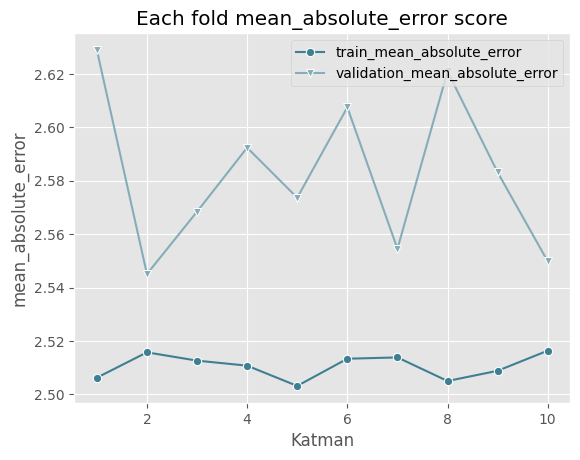

In [91]:
# Metrik MAE
kf = KFold(n_splits=10,shuffle=True,random_state=42)
xgb_model, xgb_final_test_mae_score, xgb_mae_scores_df,xgb_y_pred_test = train_and_evaluate_model(xgb, X_train, y_train, X_test, y_test, mean_absolute_error, kf, plot=True, use_rmse=False)

1. Fold train_r2_score: 0.47
1. Fold validasyon_r2_score: 0.42
2. Fold train_r2_score: 0.47
2. Fold validasyon_r2_score: 0.43
3. Fold train_r2_score: 0.47
3. Fold validasyon_r2_score: 0.42
4. Fold train_r2_score: 0.47
4. Fold validasyon_r2_score: 0.41
5. Fold train_r2_score: 0.47
5. Fold validasyon_r2_score: 0.44
6. Fold train_r2_score: 0.46
6. Fold validasyon_r2_score: 0.44
7. Fold train_r2_score: 0.46
7. Fold validasyon_r2_score: 0.44
8. Fold train_r2_score: 0.47
8. Fold validasyon_r2_score: 0.41
9. Fold train_r2_score: 0.46
9. Fold validasyon_r2_score: 0.46
10. Fold train_r2_score: 0.46
10. Fold validasyon_r2_score: 0.45
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been complated!
*******************************************
Average train_r2_score result: 0.46
Average validation_r2_score sonucu: 0.43
Test_r2_score result: 0.43
Validation percentage according to train:%-7.16
Final test percent

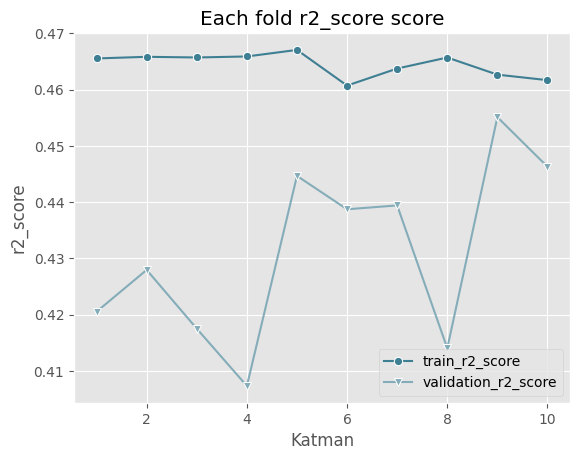

In [92]:
# Metrik R2

kf = KFold(n_splits=10,shuffle=True,random_state=42)
xgb_model, xgb_final_test_r2_score, xgb_r2_scores_df,xgb_y_pred_test = train_and_evaluate_model(xgb, X_train, y_train, X_test, y_test, r2_score, kf, plot=True, use_rmse=True)

**XGBoost Regressor Regression Özellik Seçimi**

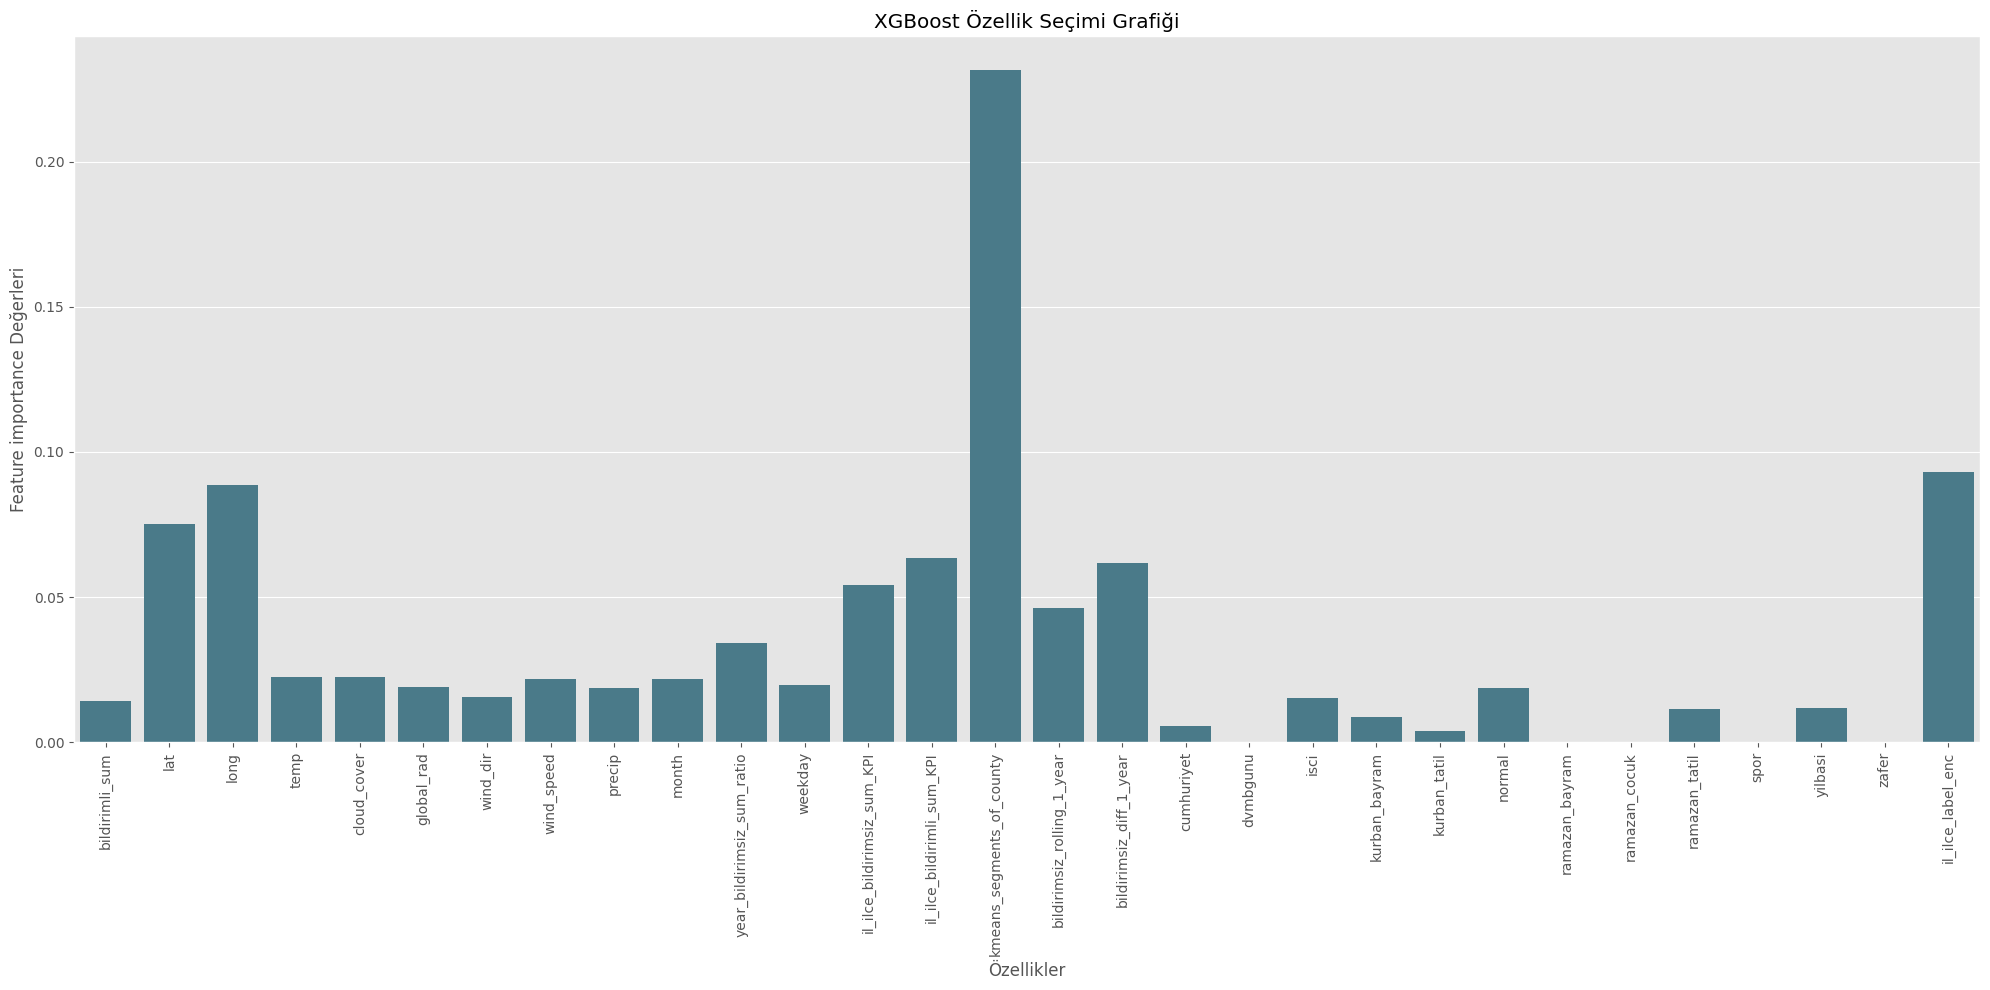

In [93]:
feature_importances = xgb_model.feature_importances_
columns = X_train.columns
plt.figure(figsize=(20,10))
sns.barplot(x=columns, y=feature_importances)
plt.xlabel("Özellikler")
plt.ylabel("Feature importance Değerleri")
plt.title("XGBoost Özellik Seçimi Grafiği")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Modellerin Karşılaştırılması**

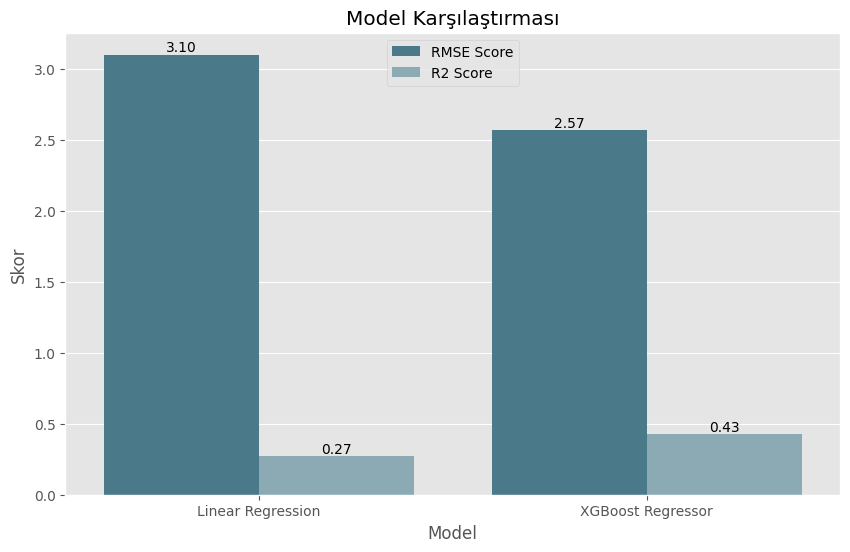

In [94]:
scores_data = {
    "Model": ["Linear Regression"] * 2 + ["XGBoost Regressor"] * 2,
    "Metrik": ["RMSE Score", "R2 Score"] * 2,
    "Skor": [lr_final_test_mae_score, lr_final_test_r2_score, xgb_final_test_mae_score, xgb_final_test_r2_score]
}
scores_df = pd.DataFrame(scores_data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="Skor", hue="Metrik", data=scores_df)
for container in ax.containers:
    ax.bar_label(container, fmt='%0.2f', label_type="edge")
plt.title("Model Karşılaştırması")
plt.ylabel("Skor")
plt.xlabel("Model")
plt.legend(loc="upper center")
plt.show()

**Son Tahmin ve Submission Oluşturulması**

In [95]:
final_test = new_test[X_train.columns]
new_test.loc[:, "bildirimsiz_sum"] = xgb_model.predict(final_test)
new_test["bildirimsiz_sum"] = round(new_test["bildirimsiz_sum"]).astype(int)
new_test[["unique_id","bildirimsiz_sum"]].head()

,unique_id,bildirimsiz_sum
0,2024-02-01-izmir-aliaga,4
1,2024-02-01-manisa-akhisar,5
2,2024-02-01-manisa-alasehir,4
3,2024-02-01-manisa-demirci,1
4,2024-02-01-manisa-golmarmara,1


In [96]:
new_test.groupby("month")["bildirimsiz_sum"].sum().reset_index()

,month,bildirimsiz_sum
0,2,4667


**il ilce bazlı tahmin kontrolü**

In [97]:
from tqdm import tqdm
def predict_for_each_county(model, new_test, columns):

    for il_ilce in tqdm(new_test['il_ilce'].unique()):
        il_ilce_data = new_test[new_test['il_ilce'] == il_ilce]
        predictions = model.predict(il_ilce_data[columns])
        new_test.loc[new_test['il_ilce'] == il_ilce, 'bildirimsiz_sum'] = predictions
        new_test["bildirimsiz_sum"] = round(new_test["bildirimsiz_sum"]).astype(int)
    print("Process succesfully complated!")
    return new_test

In [98]:
final_test = predict_for_each_county(xgb_model, new_test, X_train.columns)
final_test.groupby("month")["bildirimsiz_sum"].sum().reset_index()

100%|██████████| 47/47 [00:00<00:00, 58.04it/s]

Process succesfully complated!


,month,bildirimsiz_sum
0,2,4667


In [99]:
new_test[["unique_id","bildirimsiz_sum"]].to_csv('submissions/late_sub.csv',index=False)